# Pairs Trading using SVMs

The notebook will demo an application of SVMs that was inspired by http://cs229.stanford.edu/proj2015/028_report.pdf

In this notebook, we will explore the usage of SVMs to create a trading signal for pairs trading. One of the features we will use to generate our signal is based on the canonical pairs trading model that uses the Ornstein Uhlenbeck process and the concept of mean reversion, in addition to other signals. 

We will analyze pairs trading opportunities on GOOG and GOOGL, which are Alphabet's dual listed class A and class C stocks. This pair should share as very many intrinsic characteristics, with the exception of voting rights. 

In [130]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import datetime

import math
import scipy.stats
import sklearn
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from OU import OU
import requests
import glob

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_ticker = pd.DataFrame()

for file in glob.glob("./goog_googl_data/*"):
    columns = ["DATE", "TIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOLUME", "SPLITS", "EARNINGS", "DIVIDENDS"]
    
    goog_tmp = pd.read_csv(file + "/table_goog.csv", header=0, names=columns)
    googl_tmp = pd.read_csv(file + "/table_googl.csv", header=0, names=columns)
    
    goog_tmp['TICKER'] = "GOOG"
    googl_tmp['TICKER'] = "GOOGL"
    
    df_ticker = df_ticker.append(goog_tmp, ignore_index=True)
    df_ticker = df_ticker.append(googl_tmp, ignore_index=True)

# Data Exploration

In [3]:
df_ticker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407227 entries, 0 to 407226
Data columns (total 11 columns):
DATE         407227 non-null int64
TIME         407227 non-null int64
OPEN         407227 non-null float64
HIGH         407227 non-null float64
LOW          407227 non-null float64
CLOSE        407227 non-null float64
VOLUME       407227 non-null int64
SPLITS       407227 non-null int64
EARNINGS     407227 non-null int64
DIVIDENDS    407227 non-null int64
TICKER       407227 non-null object
dtypes: float64(4), int64(6), object(1)
memory usage: 34.2+ MB


Text(0.5, 1.0, 'Number of NaNs per column')

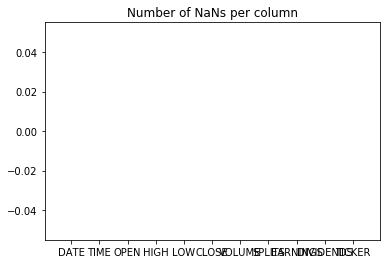

In [4]:
plt.figure()

cols = df_ticker.columns
counts = [df_ticker[x].isna().sum() for x in cols]

plt.bar(cols, counts)
plt.title("Number of NaNs per column")

In [5]:
def convert_datetime(date, time):
    ymd = date.astype("str")
    hm = time.astype("str")
    year = ymd.apply(lambda x: x[:4])
    month = ymd.apply(lambda x: x[4:6])
    day = ymd.apply(lambda x: x[6:])
    hour = hm.apply(lambda x: x[:-2])
    minute = hm.apply(lambda x: x[-2:])

    return pd.to_datetime(dict(year=year, month=month, day=day, hour=hour, minute=minute))

In [6]:
df_ticker["TIMESTAMP"] = convert_datetime(df_ticker['DATE'], df_ticker['TIME'])

df_ticker = df_ticker.sort_values(by='TIMESTAMP')

df_goog = df_ticker.query("TICKER =='GOOG'").reset_index()
df_googl = df_ticker.query("TICKER =='GOOGL'").reset_index()

In [7]:
print(df_goog.shape)
print(df_googl.shape)

(203591, 13)
(203636, 13)


The GOOG dataset has a different length than the GOOGL dataset, indicating that these dataframes have missing rows. 

From the QuantQuote website: 

Missing data for certain minutes generally means that no trades occurred during that minute. This can happen for less liquid equities which are not frequently traded. There are also situations where trades were cancelled by the exchange after being flagged by regulators or trading is halted in advance of major announcements.

Therefore, we should attempt to fill in these columns with duplicate values for the price and 0 volume for the sake of our time series analysis. 

In [8]:
goog_missing_times = set(df_goog.TIMESTAMP).difference(set(df_googl.TIMESTAMP))

googl_missing_times = set(df_googl.TIMESTAMP).difference(set(df_goog.TIMESTAMP))

total_missing_times = goog_missing_times.union(googl_missing_times)

In [9]:
df_ticker = df_ticker[~df_ticker.TIMESTAMP.isin(total_missing_times)]

In [10]:
df_goog = df_ticker.query("TICKER =='GOOG'").reset_index()
df_googl = df_ticker.query("TICKER =='GOOGL'").reset_index()

print(df_goog.shape)
print(df_googl.shape)

(203453, 13)
(203453, 13)


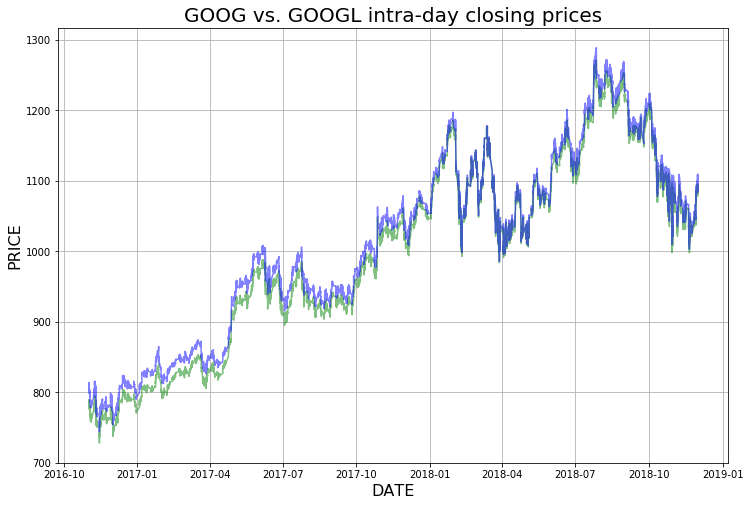

In [11]:
plt.figure(figsize=(12, 8))

plt.plot(df_goog["TIMESTAMP"], df_goog["CLOSE"], color='green', alpha=0.5, label='GOOG')
plt.plot(df_googl["TIMESTAMP"], df_googl["CLOSE"], color='blue', alpha=0.5, label='GOOGL')

plt.title('GOOG vs. GOOGL intra-day closing prices', fontsize=20)
plt.xlabel('DATE', fontsize=16)
plt.ylabel('PRICE', fontsize=16)

plt.grid()

In [12]:
# df_ticker.to_csv("./googl_googl_ticker.csv")

# Creating Trading Signals

In this section, we will generate some trading signals that we will feed in as features to our SVM classifier. All of these features are based on almost the same fundamentals, thus should very similar if not identical. The trading signals are as follows: 


### Simple Moving Averages

$$SMA_{t} = \sum_{i=t-length+1}^{t}Price_{i}$$

The length parameter needs to be tuned based on how near term we want to profit after performing a trade in minutes. This parameter gives us historical temporal relationships within the current price. 

In [13]:
def sma(prices, window):
    """
    Return the Simple Moving Average of the Prices
    
    :prices: pandas Series containing the prices of the ticker
    :window: window size
    
    :ret: Moving average of prices
    """
    return prices.rolling(window).mean()[window:]

### Exponential Weighted Moving Averages

$$WMA_{t} = \sum_{i=t-length+1}^{t}Weight_{i}Price_{i}$$

$$Weight_{i} = \frac{i-(t-length)}{\sum_{j=t-length+1}^{t}j-(t-length)}$$

Weighted moving average works the same way as the simple moving average, but it weighs more recent information heavier. 

In [14]:
def ewma(prices, window):
    """
    Return the Weighted Moving Average of the Prices
    
    :prices: pandas Series containing the prices of the ticker
    :window: window size
    
    :ret: Moving average of prices
    """                      
    return pd.Series.ewm(prices, span=window).mean()[window:]

### Spread of Money FLOW Indices

$$MFI_t = 100 - (\frac{100}{1+Money FLOW Ratio_t})$$

$$Money FLOW Ratio_t = \frac{length - Period Positive Money FLOW_{i}}{length - Period Negative Money FLOW_{i}}$$

$$MoneyFLOW_{t} = VOLUME * \frac{P_{HIGH} + P_{LOW} + P_{CLOSE}}{3}$$

Where Money FLOW is positive if:

$$\frac{P_{HIGH}(t) + P_{LOW}(t) + P_{CLOSE}(t)}{3} > \frac{P_{HIGH}(t-1) + P_{LOW}(t-1) + P_{CLOSE}(t-1)}{3}$$

This feature is useful because it incorporates information about VOLUME.

In [15]:
def mfi(df, window):
    """
    Calculates money fLOW and money fLOW indices. 
    
    :df: ticker dataframe
    :window: window size
    
    :ret: money fLOW indices of each point
    """    
    mf = (df['HIGH'] + df['LOW'] + df['CLOSE']) / 3
    i = 0
    pos_mf = [0]
    neg_mf = [0]
    
    # Find Positive Money FLOWs and Negative Money FLOWs
    while i < df.index[-1]:
        if mf[i + 1] > mf[i]:
            pos_mf.append(mf[i + 1] * df.loc[i + 1, 'VOLUME'])
            neg_mf.append(0)
        else:
            pos_mf.append(0)
            neg_mf.append(mf[i + 1] * df.loc[i + 1, 'VOLUME'])
        i = i + 1
        
    pos_mf = pd.Series(pos_mf)
    neg_mf = pd.Series(neg_mf)
    
    # Apply a cumulative sum over every window
    pos_sum = pd.Series(pos_mf.rolling(window).sum())
    neg_sum = pd.Series(neg_mf.rolling(window).sum())
    
    mfr = (window - pos_sum)/(window-neg_sum)
    mfi = abs(100 - (100 / (1+mfr)))
    
    return mfi[window:]


### Relative Strength Indices

$$RSI_{t} = 100 - (\frac{100}{1+RS_{t}})$$

$$RS_{t} = \frac{avg(length-period up CLOSEs)}{avg(length-period down CLOSEs)}$$

RSI  is  good  at  indicating  whether  the  stock  is  in  over-
sought or overbought condition.


In [16]:
def rsi(df, window):
    """
    Calculate Relative strength index. First we identify positive and negative closing periods, 
    and then sum over them separately. Then we find the ratio
    
    :df:         Ticker dataframe.
    :window:     Window size. 
    
    :ret: Series of RSIs.
    """
    i = 0
    pos_period = [0]
    neg_period = [0]
    
    # Identify positive and negative closing periods
    while i < df.index[-1]:
        if df.at[i+1, 'CLOSE'] > df.at[i, 'CLOSE']:
            pos_period.append(df.at[i+1, 'CLOSE'])
            neg_period.append(0)
        else:
            pos_period.append(0)
            neg_period.append(df.at[i, 'CLOSE'])
        i = i + 1
        
    pos_period = pd.Series(pos_period)
    neg_period = pd.Series(neg_period)
    
    # Apply rolling sum over all of our windows
    pos_sum = pd.Series(pos_period.rolling(window).sum())
    neg_sum = pd.Series(neg_period.rolling(window).sum())
    
    # Normalize with window length to ensure that we don't have 0 in the denominator
    rs = (window - pos_sum)/(window-neg_sum)
    rsi = abs(100 - (100 / (1+rs)))
    
    return rsi[window:]

In [17]:
def create_label_func(threshold=1, window=5):
    """
    Given the spreads of residuals between our pair, label as 1 if the spread change exceeds 
    the threshold, and 0 otherwise. 
    
    :residuals: spreads between the residuals of the pair
    :window: how far in the future in minutes we want to evaluate our position on
    :threshold: the percent change threshold that determines whether a trade is profitable or not. 
    
    :ret: list of labels of 1 or -1.
    """
    def create_labels(residuals):
        min_val = residuals[::-1].rolling(window=window).min()[::-1]
        min_val.iloc[-window:] = residuals.iloc[-window:]

        a = (residuals-min_val) > threshold
        labels = a.astype(int)
        
        return labels
    
    return create_labels

### Ornstein Uhlenbeck Process to model Residual Terms

The canonical pairs trading model is as follows:

$$\frac{dA_t}{A_t} = \alpha dt + \beta\frac{dB_t}{B_t} + dX_t$$

where $A_t$ is the price of security $A$ at time $t$, $B_t$ is the price of security $B$ at time $t$,
$X_t$ is the residual term, which has the mean-reverting property because mean-reverting
spread is the basic assumption of pairs trading and the drift term, $\alpha dt << \beta\frac{dB_t}{B_t}$, which is neglectable compared to the return of either security.  

The above model shows that
the stock price of the two securities is linear related. The $\beta$ here  helps  solve  the  normalization  problem  since  the two stock prices may not fluctuate in the same range. Furthermore, $\beta$
may change over time because of change of some intrinsic characteristics of either company or change
of overall stock market regime, however, in this project, we assume $\beta$ is a constant term over the duration of the dataset.

In this project, we will use ‘CLOSE’ - ‘OPEN’ as $dB_t$ and 'OPEN' as $B_t$. Same applies for $dA_t$ and $A_t$

We  will  use  Ornstein-Uhlenbeck  process to model the residual term because the O-U process is a
stochastic  process  such  that  the  object  modeled  by  the process  always  drifts  towards  its 
long-term  mean. The residual term, namely the spread, has very similar property according the assumption of pairs trading. The residual term $X_t$ from  the  above  spread  model  satisfies  the
folLOWing stochastic differential equation:

# Feature Creation

In [18]:
feature_window = 5

df_goog['sma'] = sma(df_goog['CLOSE'], feature_window).pct_change()
df_googl['sma'] = sma(df_googl['CLOSE'], feature_window).pct_change()

df_goog['ewma'] = ewma(df_goog['CLOSE'], feature_window).pct_change()
df_googl['ewma'] = ewma(df_googl['CLOSE'], feature_window).pct_change()

df_goog['mfi'] = mfi(df_goog, feature_window).pct_change()
df_googl['mfi'] = mfi(df_googl, feature_window).pct_change()

df_goog['rsi'] = rsi(df_goog, feature_window).pct_change()
df_googl['rsi'] = rsi(df_googl, feature_window).pct_change()

df_goog['price'] = df_goog['CLOSE'].pct_change()
df_googl['price'] = df_googl['CLOSE'].pct_change()

df_gg = df_goog[feature_window+1:].reset_index(drop=True)
df_ggl = df_googl[feature_window+1:].reset_index(drop=True)

In [19]:
# Set Label definition Hyperparameters. 

threshold=0.0005
window=5
label_func = create_label_func(threshold=threshold, window=window)

In [222]:
s1= df_gg
s2= df_ggl
a = OU(s1, s2)
a.split_slide(m_size=3000, e_size=100)
info = a.get_splits(['price', 'sma', 'ewma', 'mfi', 'rsi'], label_func=label_func, scale=True)
len(info)

Sliding Window Split Successful.


2005

# Exploring the Labelled Dataset

In [223]:
# Approximately 35% of the dataset has a trade signal label. 
labels = np.hstack(np.array([fold['test']['labels'].values for fold in info]))
np.bincount(labels)

array([131997,  68450])

In [224]:
plot = False

In [225]:
if plot: 
    for fold, thing in enumerate(info):
        train = thing['train']
        test = thing['test']

        train_residuals = train['residuals_fit_price']
        test_residuals = test['residuals_transform_price']
        window=5

        min_val_train = train_residuals[::-1].rolling(window=window).min()[::-1]
        min_val_test = test_residuals[::-1].rolling(window=window).min()[::-1]

        fig = plt.figure(figsize=(8, 6))
        ax1 = plt.subplot(1, 2, 1)
        ax2 = plt.subplot(1, 2, 2, sharey=ax1)


        ax1.boxplot((train_residuals - min_val_train)[:-window])
        ax1.set_title('TRAIN')
        ax1.axhline(threshold, linestyle='dashed', color='black', alpha=0.7)
        ax1.grid()

        ax2.boxplot((test_residuals - min_val_test)[:-window])
        ax2.set_title('TEST')

        ax2.grid()
        ax2.axhline(threshold, linestyle='dashed', color='black', alpha=0.7)

        plt.suptitle('Fold %d' % fold)
        plt.savefig(save_dir + 'residual_plots/fold%d.jpg' % fold)
        plt.close(fig)

Now we are going to investigate all of our evaluation periods to find the total profit possible from exploiting downwards correction in the residual of the price. 

This is assuming that we take a long position of $\beta$ units of stock $B$ and a short position of $1$ unit of stock $A$ whenever we obtain a trading signal. We will hold this position until either the residual of the spread of the returns drops by $threshold$, or $window$ amount of time has elapsed, in which case we will offload our position. 

In [226]:
def backtest(preds, df_test):
    """
    Performs P/L Backtesting given some prediction labels and a test dataframe. 
    
    :preds: Array of trade signals corresponding to the dataframe.
    :df_test: DataFrame of test ticker data. 

    """
    backtest_results = {}
    
    total_profit = 0.0

    profit_timeline = []
    trade_profit_timeline = []
    time_held_timeline = []
    
    trades_data = []
    
    df_temp = df_test.copy()
    df_temp['label'] = preds

    for row in df_temp.iterrows():
        cur_profit = 0.0
        profit = row[1]['profit']
        residual = row[1]['residual']
        for position in trades_data:
            position['fresh'] += 1
            position['profit'] += profit
            if (position['residual'] - threshold <= residual) or position['fresh'] >= window:
                cur_profit+=position['profit']
                # To keep track of average trade value. 
                trade_profit_timeline.append(position['profit'])
                time_held_timeline.append(position['fresh'])
                trades_data.remove(position)
        profit_timeline.append(cur_profit)
        total_profit+=cur_profit

        if row[1]['label']:
            trades_data.append({'profit': 0, 'residual': residual, 'fresh': 0})
            
    backtest_results['total_profit'] = total_profit
    backtest_results['']
    
    
    return total_profit

In [227]:
def create_pl_df(df_ticker1, df_ticker2, info):
    """
    Creates a comprehensive DataFrame by combining the ticker data from the given tickers 
    with the residual information calculated in the OU class. 

    Saves this DataFrame to self.df_residual. 
    
    ## TODO: Rewrite GOOG/GOOGL Labels to make more abstract. 

    :df_ticker1: Ticker data from first asset. 
    :df_ticker2: Ticker data from second asset. 
    :info: Fold dictionary calculated from OU class. 

    """
    ticker1_name = df_ticker1['TICKER']
    ticker2_name = df_ticker2['TICKER']
    
    df_test_only = pd.DataFrame()
    df_test_only_labels = pd.Series()

    for i in info:
        idx = i['test']['index']
        residuals = i['test']['residuals_transform_price']
        beta = i['train']['beta_fit_price']
        df_temp = pd.concat([df_ticker1.loc[idx]['CLOSE'], 
                             beta * df_ticker2.loc[idx]['CLOSE'], 
                             df_ticker1.loc[idx]['price'], 
                             beta * df_ticker2.loc[idx]['price'], 
                             i['test']['residuals_transform_price'], 
                             df_ticker1.loc[idx]['TIMESTAMP']
                            ], axis=1)
        df_test_only = df_test_only.append(df_temp)
        df_test_only_labels = df_test_only_labels.append(i['test']['labels'])

    df_test_only['label'] = df_test_only_labels
    df_test_only.columns=['GOOG', 'beta*GOOGL', 'GOOG_return', 
                          'beta*GOOGL_return', 'residual', 'TIMESTAMP', 'label']

    # Find Profit of last trade given percent returns. 
    # (y-(1-deltaY)y) - (x-(1-deltaX)x)
    df_test_only['beta*GOOGL_gains'] = df_test_only['beta*GOOGL']-(1-df_test_only['beta*GOOGL_return'])*df_test_only['beta*GOOGL']
    df_test_only['GOOG_gains'] = df_test_only['GOOG']-(1-df_test_only['GOOG_return'])*df_test_only['GOOG']
    df_test_only['profit'] = df_test_only['beta*GOOGL_gains'] - df_test_only['GOOG_gains']

    print('P/L Dataframe saved as "df_residual" parameter.')
    return df_test_only

In [228]:
def param_format(params):
    """
    Function that formats a dictionary of parameters into a string that is 
    writeable to a file/directory. 
    
    :params: Parameter Dictionary to format. 
    
    :ret: Stringified version of the parameter dictionary. 
    """
    param_str = ', '.join("{!s}-{!r}".format(key,val) for (key,val) in params.items())
    param_str = param_str.replace("{", "")
    param_str = param_str.replace("}", "")
    param_str = param_str.replace("'", "")
    param_str = param_str.replace(",", "_")
    param_str = param_str.replace(" ", "")
    param_str = param_str.replace(":", "")
    param_str = param_str.replace(".", "")
    param_str = param_str.strip()
    
    return param_str

In [272]:
def sharpe(df_temp):
    """
    Takes in a profit/loss dataframe with labels and finds the Sharpe Ratio according to 
    the following formula: 
    
    Daily P/L / Standard Dev(Daily P/L) x sqrt(252)
    
    :df_temp: Profit/loss dataframe. 
    
    :ret: Sharpe Ratio.
    """
    daily_profit = df_temp.groupby(by = 
                                   [df_temp.TIMESTAMP.dt.year, 
                                    df_temp.TIMESTAMP.dt.month, 
                                    df_temp.TIMESTAMP.dt.day])['profit_timeline'].sum()
    
    return np.mean(daily_profit)/np.std(daily_profit) * np.sqrt(252)


def sortino(df_temp):
    """
    Takes in a profit/loss dataframe with labels and finds the Sortino Ratio according to 
    the following formula: 
    
    Daily P/L / Standard Dev(Negative Daily P/L) x sqrt(252)
    
    :df_temp: Profit/loss dataframe. 
    
    :ret: Sortino Ratio.
    """
    daily_profit = df_temp.groupby(by = 
                                   [df_temp.TIMESTAMP.dt.year, 
                                    df_temp.TIMESTAMP.dt.month, 
                                    df_temp.TIMESTAMP.dt.day])['profit_timeline'].sum()
    
    return np.mean(daily_profit)/np.std([pl for pl in daily_profit if pl < 0]) * np.sqrt(252)
    

def precision(pred, label):
    return (pred[np.logical_and(pred==1, label==1)].shape[0])/pred[pred==1].shape[0]


def fit(params, info):
    """
    Fit a SVM according to the parameters across all folds in the info dictionary. 
    Returns a flattened numpy array of prediction labels across all folds. 

    Adds the labels for the parameter to the residual graph. 

    :params: Model Hyperparameters.
    :info_dict: Associated Info Dict.

    :ret: Numpy array of predictions.
    """
    preds = []

    for i in info:
        b_svm = svm.SVC(**params)
        b_svm.fit(i['train']['df_scale'], i['train']['labels'])
        pred = b_svm.predict(i['test']['df_scale'])
        preds.append(pred)
        
    return np.hstack(np.array(preds))


def find_profit_loss(df_test, preds, params, window=5, threshold=0.0005, plot=True, save_dir=None):
    """
    Performs P/L Backtesting given some prediction labels and a test dataframe. 

    Returns a dictionary of results. 
    
    :df_test: DataFrame of profit loss. 
    :preds: Prediction Labels: 
    :params: Name of Params of model tested. 
    :window: Evaluation window for how long we want to hold on to our position. 
    :threshold: how much of a residual shift determines a trade being offloaded. 
    :plot: Flag for evaluation plots. 
    :save_dir: Folder to save evaluation plots. 
    
    :ret: results. 
    """
    backtest_results = {}
    # Turn params into string for file output
    param_str = param_format(params)
    print("Finding Profit/Loss for model with parameters: %s." % param_str)
    total_profit = 0.0
    
    # Daily profit p/l
    profit_timeline = []
    # Per trade p/l
    trade_profit_timeline = []
    # Amount of minutes held per trade
    time_held_timeline = []
    # Trades held portfolio
    trades_data = []

    df_temp = df_test.copy()
    df_temp['label'] = preds

    for row in df_temp.iterrows():
        cur_profit = 0.0
        profit = row[1]['profit']
        residual = row[1]['residual']
        
        # For each currently held trade in portfolio, adjust freshness and profit with each timestep. 
        for position in trades_data:
            position['fresh'] += 1
            position['profit'] += profit
            # If the residual crosses the threshold or the time runs out, unload the trade. 
            if (position['residual'] - threshold <= residual) or position['fresh'] >= window:
                cur_profit+=position['profit']
                # To keep track of average trade value. 
                trade_profit_timeline.append(position['profit'])
                time_held_timeline.append(position['fresh'])
                trades_data.remove(position)
        profit_timeline.append(cur_profit)
        total_profit+=cur_profit

        if row[1]['label']:
            trades_data.append({'profit': 0, 'residual': residual, 'fresh': 0})
            
    # Appends daily p/l array to array for easier calculations in the future.         
    df_temp['profit_timeline'] = profit_timeline
    
    backtest_results['total_profit'] = total_profit
    backtest_results['daily_profit_timeline'] = profit_timeline
    backtest_results['trade_profit_timeline'] = trade_profit_timeline
    backtest_results['time_held_timeline'] = time_held_timeline
    backtest_results['trades_executed'] = len(trade_profit_timeline)
    backtest_results['params'] = params
    backtest_results['precision'] = precision(df_temp['label'], df_test['label'])
    backtest_results['mean_profit_per_trade'] = np.mean(trade_profit_timeline)
    backtest_results['sharpe'] = sharpe(df_temp)
    backtest_results['sortino'] = sortino(df_temp)
    
    if plot:
        # Plot Total Profit
        min_date = df_temp.TIMESTAMP.min()
        max_date = df_temp.TIMESTAMP.max()
        plt.figure()
        plt.plot(np.cumsum(profit_timeline), color='green')
        plt.xlabel('Time')
        plt.ylabel('P/L')
        plt.xlim([0, df_temp.shape[0]])
        plt.ylim([0, 12000])
        plt.title('Total P/L from %s to %s \n Window=%d, threshold = %0.5f \n Model Parameters: %s' % (min_date, max_date, window, threshold, params))
        plt.grid()
        plt.savefig(save_dir + 'total_pl_' + param_str +'.jpg')

        # Plot Time Held Histogram
        plt.figure()
        plt.hist(time_held_timeline, bins=5, linestyle='solid', edgecolor='black', color='red')
        ax = plt.gca()
        plt.xlabel('Histogram of Minutes held per trade')
        plt.ylabel('Frequency')
        plt.grid()
        plt.xlim([1, window])
        plt.title('Minutes held per trade \n Model Parameters: %s' % params)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.savefig(save_dir + '/' + param_str +'minutes_held_hist.jpg')
        
        # Plot Minutes Held vs. Profit Scatter Plot
        plt.figure()
        ax = plt.gca()
        plt.scatter(trade_profit_timeline, time_held_timeline)
        plt.xlabel('Profit/Loss')
        plt.ylabel('Minutes Held')
        plt.title('Minutes Held vs. Profit/Loss')
        plt.grid()
        ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
        plt.savefig(save_dir + '/' + param_str +'minutes_held_hist.jpg')
        
        # Average Trade Histogram
        plt.figure()
        ax = plt.gca()
        plt.hist(trade_profit_timeline, bins=1000)
        plt.xlabel('Profit/Loss')
        plt.ylabel('Frequency')
        plt.title('Histogram of Profit/Loss per Trade\n Average Trade: %0.4f\n Median Trade: %0.4f' % (np.mean(trade_profit_timeline), np.median(trade_profit_timeline)))
        plt.axvline(np.median(trade_profit_timeline), label='Median', linestyle='dashed')
        plt.grid()
        ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
        plt.savefig(save_dir + '/' + param_str +'_average_trade_hist.jpg')
        
    return backtest_results


In [255]:
params = {'C': 100,
   'cache_size': 2000,
   'class_weight': {0: 0.5, 1: 0.5},
   'gamma': 1,
   'kernel': 'rbf'}

In [256]:
df_pl = create_pl_df(df_gg, df_ggl, info)

P/L Dataframe saved as "df_residual" parameter.


In [257]:
labels = fit(params, info)

In [258]:
save_dir = './dfs/2019_01_07_3000_100_tscore_close_mfi_rsi_openclose/'

Finding Profit/Loss for model with parameters: C-100_cache_size-2000_class_weight-005_105_gamma-1_kernel-rbf.


{'total_profit': 4299.398862866011,
 'daily_profit_timeline': [0.0,
  0.0,
  -0.08572001722734512,
  -0.1330941217822783,
  -0.20442253823853207,
  -0.3065308959937738,
  0.1357767316034142,
  0.05062100297584493,
  0.010897390267928131,
  -0.5525414877878347,
  0.0,
  0.45061723643107143,
  0.4833241599808389,
  0.0,
  0.14523622712806628,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.2814755372320406,
  0.0,
  0.0,
  0.0,
  0.0,
  0.2499156175723556,
  0.0,
  0.2584935545295366,
  -0.437505912986353,
  0.0,
  -0.5557085477890951,
  0.16761943155938752,
  -0.09616885893842664,
  0.33088185743065424,
  -0.19408139242807465,
  0.33005417541573934,
  -0.09566281185664138,
  -0.11351822230164998,
  -0.027581449577382955,
  0.3438957825719626,
  0.07933794184464205,
  0.44569529966281607,
  -0.3725080243375487,
  -0.137077679066806,
  0.5046308828989368,
  -0.11213668353025241,
  0.05918335265926089,
  -0.18100736972905906,
  -0.61032718155559,
  0.11520228604979366,
  0.0,
  1.0017

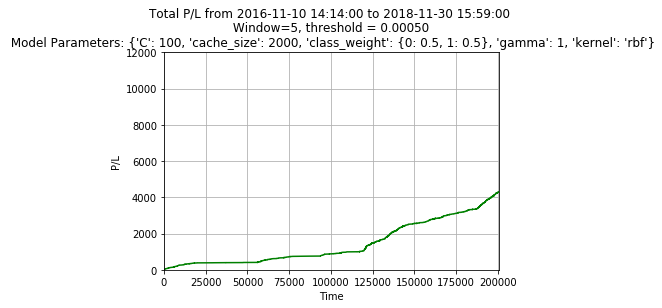

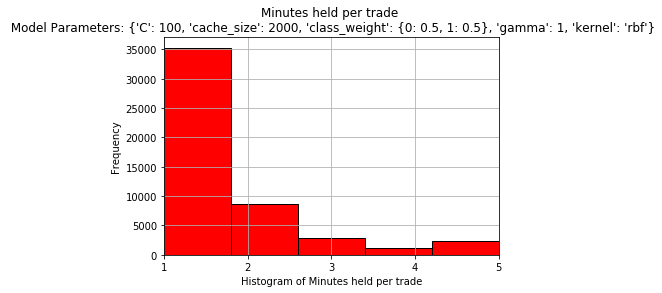

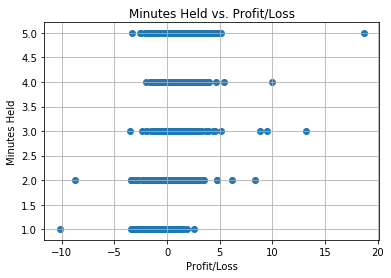

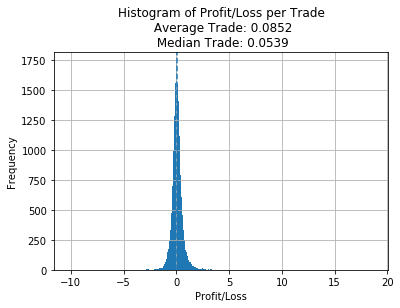

In [273]:
find_profit_loss(df_pl, labels, params, save_dir=save_dir)

# GRIDSEARCHCV

In [230]:
splits = []
multi_cv_df = pd.DataFrame()
multi_cv_labels = pd.Series()

for i in range(len(info)):
    train = info[i]['train']['df_scale'].copy()
    train_labels = info[i]['train']['labels'].copy()
    
    test = info[i]['test']['df_scale'].copy()
    test_labels = info[i]['test']['labels'].copy()
    
    train_len = train.shape[0]
    test_len = test.shape[0]
    
    multi_cv_df = multi_cv_df.append(train, ignore_index=True)
    multi_cv_labels = multi_cv_labels.append(train_labels, ignore_index=True)
    
    multi_cv_df = multi_cv_df.append(test, ignore_index=True)
    multi_cv_labels = multi_cv_labels.append(test_labels, ignore_index=True)
    
    splits.append((multi_cv_df.iloc[-train_len-test_len:-test_len].index, multi_cv_df.iloc[-test_len:].index))
    assert(np.array_equal(multi_cv_df.loc[splits[i][0]].values, train.values))
    assert(np.array_equal(multi_cv_labels.loc[splits[i][0]].values, train_labels.values))
    assert(np.array_equal(multi_cv_df.loc[splits[i][1]], test.values))
    assert(np.array_equal(multi_cv_labels.loc[splits[i][1]], test_labels))
    
splits = np.array(splits)

np.save(save_dir + 'splits.npy', splits)

In [241]:
save_dir = './dfs/2019_01_07_3000_100_tscore_close_mfi_rsi_openclose/'

In [243]:
multi_cv_df.to_csv(save_dir + 'df.csv')

multi_cv_labels.to_csv(save_dir + 'labels.csv')

In [244]:
multi_cv_df = pd.read_csv(save_dir + 'df.csv')
multi_cv_labels = pd.read_csv(save_dir + 'labels.csv')

In [232]:
# class weight optimization?
params = [{'kernel': ['rbf'], 'C': [0.1,1,10,100], 
            'gamma': [1, 0.1, 0.001, 0.0001], 
            'cache_size': [2000], 
            'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.6, 1: 0.4}, {0: 0.7, 1: 0.3}, {0: 0.8, 1: 0.2}]}, 
          {'kernel': ['poly'], 'C': [0.1, 1,10,100,], 
           'gamma': [1, 0.1, 0.001, 0.0001], 'degree': [3, 5], 
           'cache_size': [2000], 
           'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.6, 1: 0.4}, {0: 0.7, 1: 0.3}]}]

In [ ]:
models = [

{'C': [100], 'cache_size': [2000], 'class_weight': [{0: 0.5, 1: 0.5}], 'gamma': [1], 'kernel': ['rbf']}, 
{'C': [100], 'cache_size': [2000], 'class_weight': [{0: 0.6, 1: 0.4}], 'gamma': [1], 'kernel': ['rbf']}, 
{'C': [10], 'cache_size': [2000], 'class_weight': [{0: 0.6, 1: 0.4}], 'gamma': [1], 'kernel': ['rbf']}, 
{'C': [1], 'cache_size': [2000], 'class_weight': [{0: 0.5, 1: 0.5}], 'gamma': [1], 'kernel': ['rbf']}, 

# {'C': [100], 'cache_size': [2000], 'class_weight': [{0: 0.5, 1: 0.5}], 'degree': [5], 'gamma': [1], 'kernel': ['poly']}, 
# {'C': [100], 'cache_size': [2000], 'class_weight': [{0: 0.7, 1: 0.3}], 'degree': [5], 'gamma': [1], 'kernel': ['poly']}, 
# {'C': [100], 'cache_size': [2000], 'class_weight': [{0: 0.6, 1: 0.4}], 'degree': [5], 'gamma': [1], 'kernel': ['poly']}, 
# {'C': [1], 'cache_size': [2000], 'class_weight': [{0: 0.5, 1: 0.5}], 'degree': [3], 'gamma': [1], 'kernel': ['poly']}, 
# {'C': [1], 'cache_size': [2000], 'class_weight': [{0: 0.5, 1: 0.5}], 'degree': [3], 'gamma': [1], 'kernel': ['poly']}, 
    
]

In [159]:
models = [

{'C': 100, 'cache_size': 2000, 'class_weight': {0: 0.5, 1: 0.5}, 'gamma': 1, 'kernel': 'rbf'}, 
{'C': 100, 'cache_size': 2000, 'class_weight': {0: 0.6, 1: 0.4}, 'gamma': 1, 'kernel': 'rbf'}, 
{'C': 10, 'cache_size': 2000, 'class_weight': {0: 0.6, 1: 0.4}, 'gamma': 1, 'kernel': 'rbf'}, 
{'C': 1, 'cache_size': 2000, 'class_weight': {0: 0.5, 1: 0.5}, 'gamma': 1, 'kernel': 'rbf'}, 
    
# {'C': 100, 'cache_size': 2000, 'class_weight': {0: 0.5, 1: 0.5}, 'degree': 5, 'gamma': 1, 'kernel': 'poly'}, 
# {'C': 100, 'cache_size': 2000, 'class_weight': {0: 0.7, 1: 0.3}, 'degree': 5, 'gamma': 1, 'kernel': 'poly'}, 
# {'C': 100, 'cache_size': 2000, 'class_weight': {0: 0.6, 1: 0.4}, 'degree': 5, 'gamma': 1, 'kernel': 'poly'}, 
    
# {'C': 1, 'cache_size': 2000, 'class_weight': {0: 0.5, 1: 0.5}, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}, 
# {'C': 1, 'cache_size': 2000, 'class_weight': {0: 0.5, 1: 0.5}, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}, 
    
]

In [233]:
gridcv = GridSearchCV(svm.SVC(), params, verbose=1, cv=list(splits), n_jobs=-1, 
                    scoring=['precision'], refit=False)
gridcv.fit(multi_cv_df, multi_cv_labels)

Fitting 2005 folds for each of 160 candidates, totalling 320800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

GridSearchCV(cv=[array([RangeIndex(start=0, stop=3000, step=1),
       RangeIndex(start=3000, stop=3100, step=1)], dtype=object), array([RangeIndex(start=3100, stop=6100, step=1),
       RangeIndex(start=6100, stop=6200, step=1)], dtype=object), array([RangeIndex(start=6200, stop=9200, step=1),
       RangeIndex...2400, stop=6215400, step=1),
       RangeIndex(start=6215400, stop=6215447, step=1)], dtype=object)],
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.001, 0.0001], 'cache_size': [2000], 'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.6, 1: 0.4}, {0: 0.7, 1: 0.3}, {0: 0.8, 1: 0.2}]}, {'kernel': ['poly'], 'C': [0.1,

In [234]:
import pickle

In [242]:

with open(save_dir+'results.pkl', 'wb') as f:
    pickle.dump(gridcv, f) # save the object to a file

# with open(save_dir+'results_rbf_only.pkl', 'rb') as f:
#     gridcv = pickle.load(f)

In [245]:
prec_recs = pd.DataFrame()
for i in range(len(info)):
    precs = gridcv.cv_results_['split%d_test_precision'% i]
    prec_recs = prec_recs.append(pd.DataFrame(precs).T)

In [246]:
prec_recs = prec_recs.reset_index(drop=True)

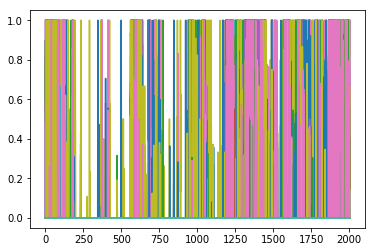

In [247]:
plt.plot(prec_recs)

/home/alex/.conda/envs/analysis/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


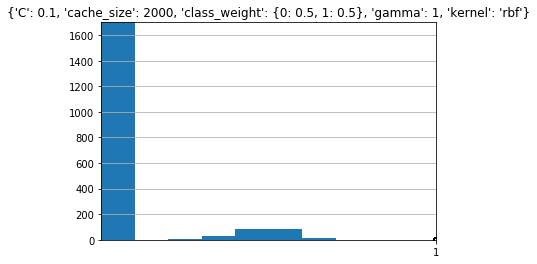

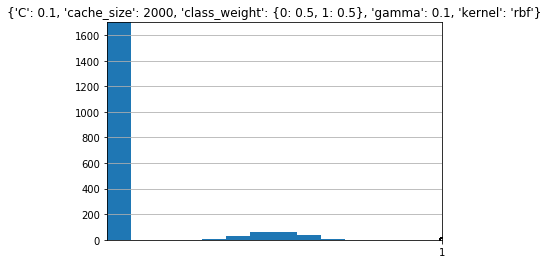

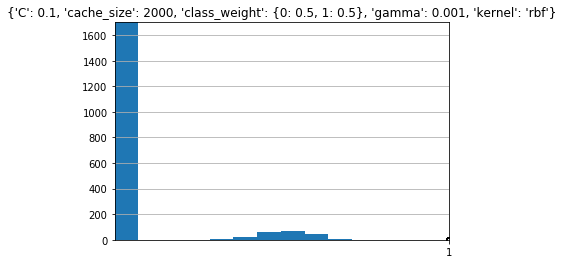

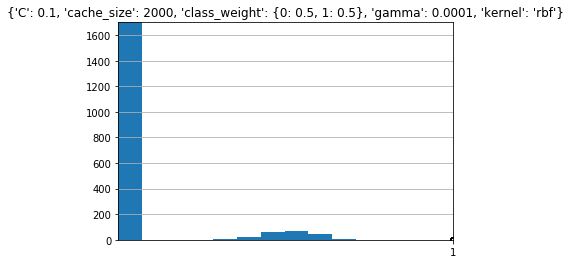

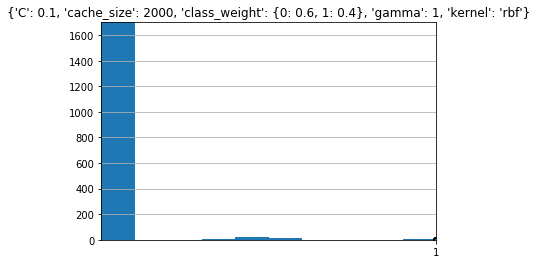

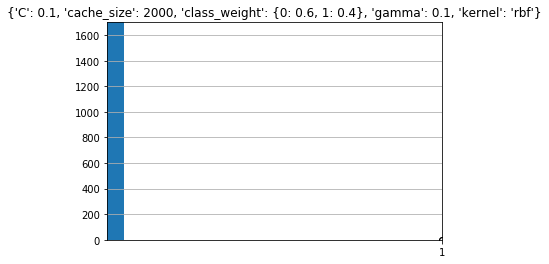

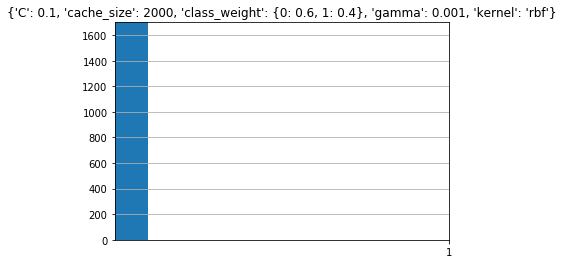

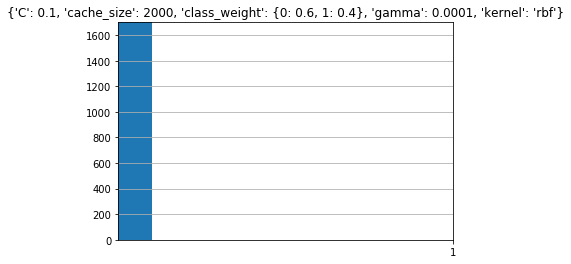

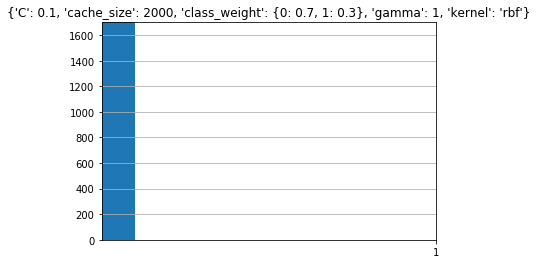

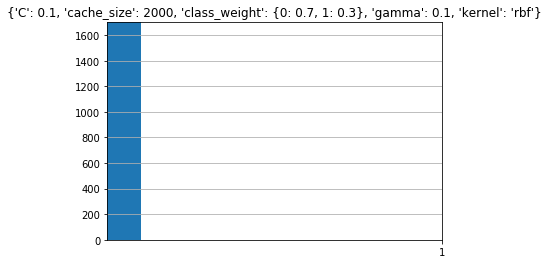

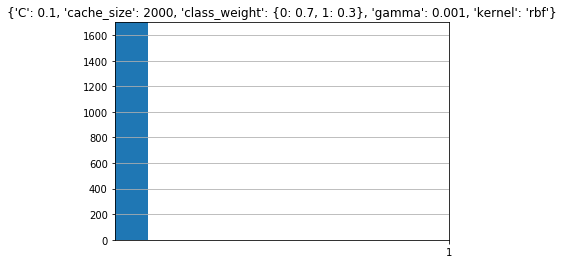

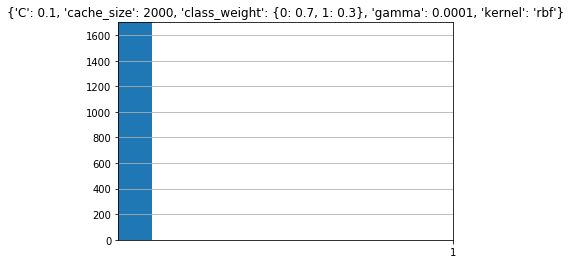

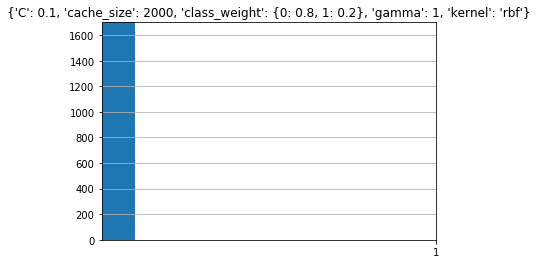

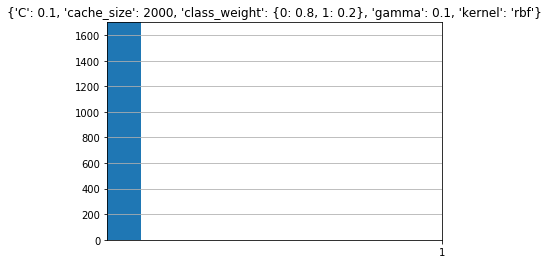

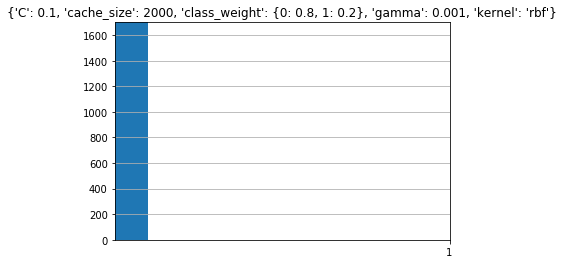

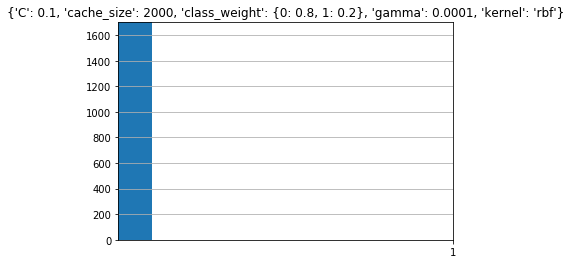

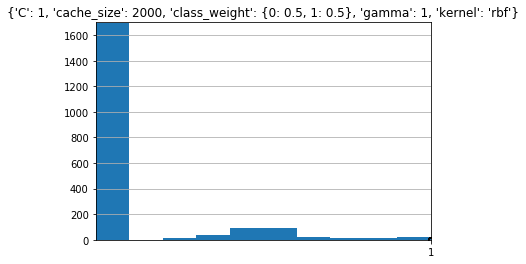

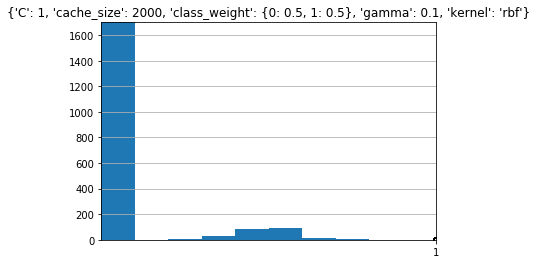

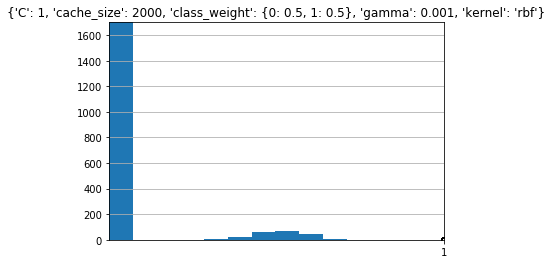

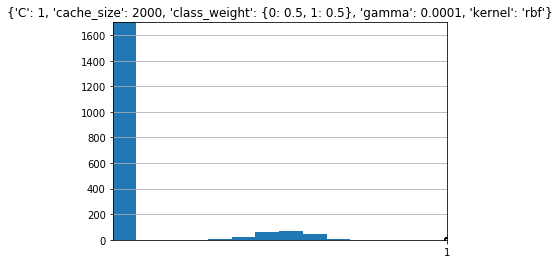

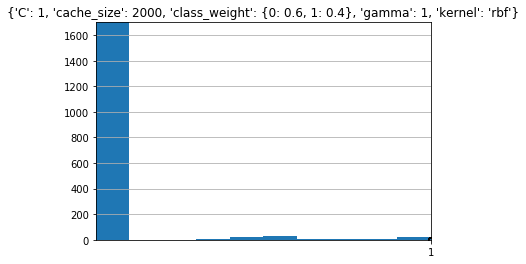

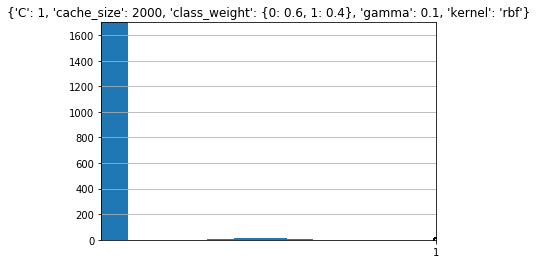

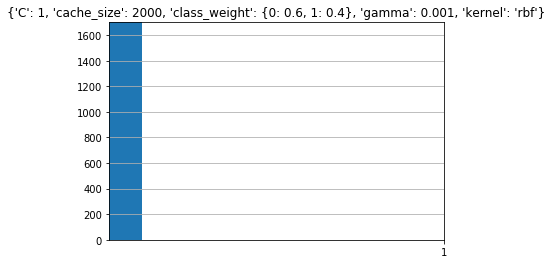

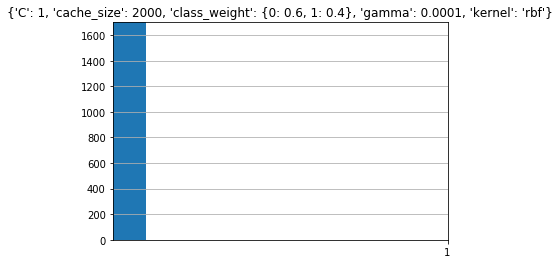

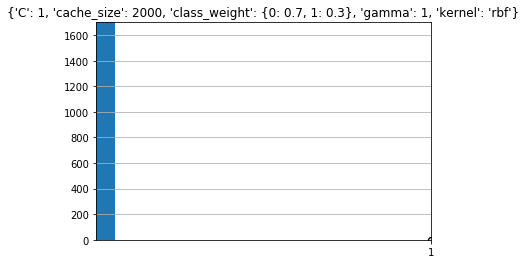

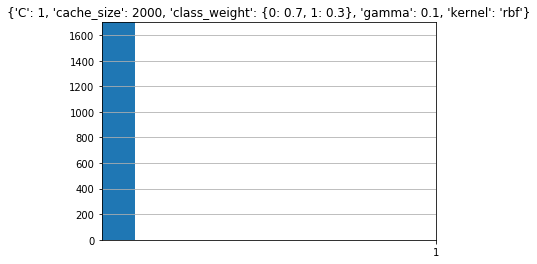

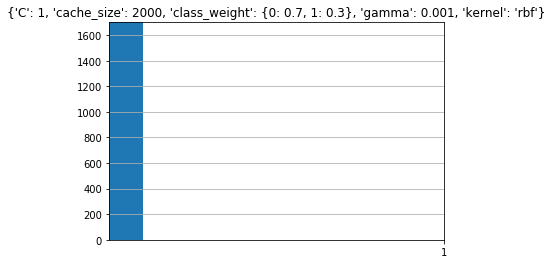

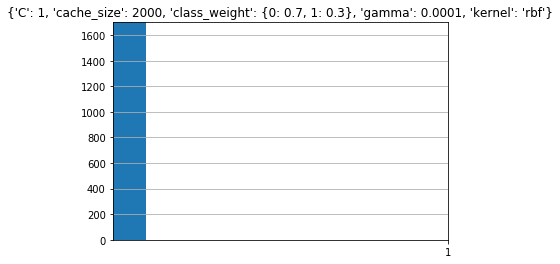

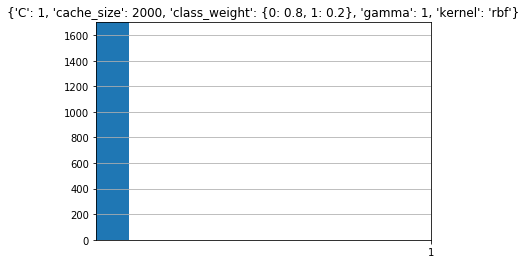

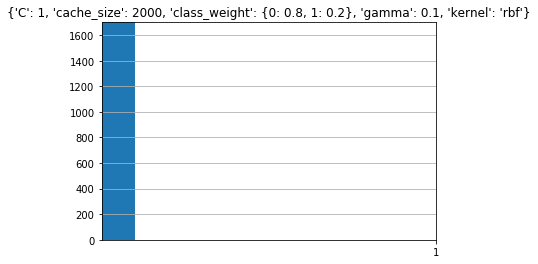

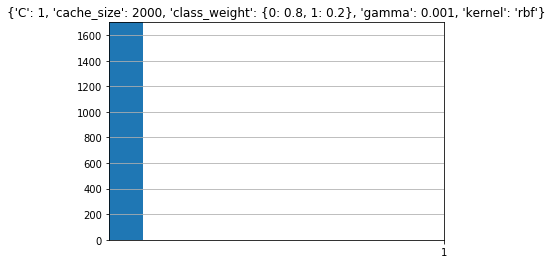

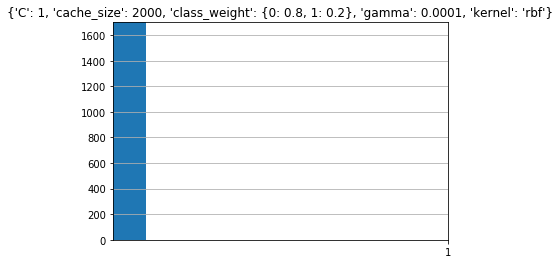

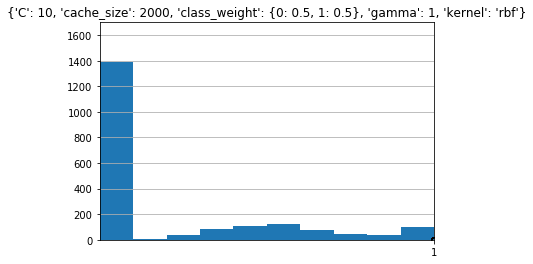

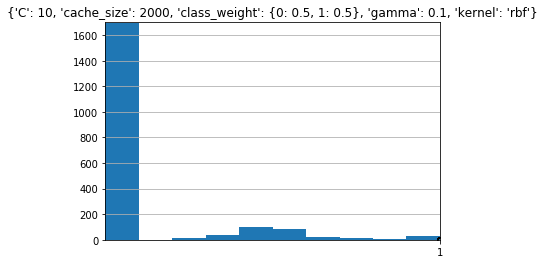

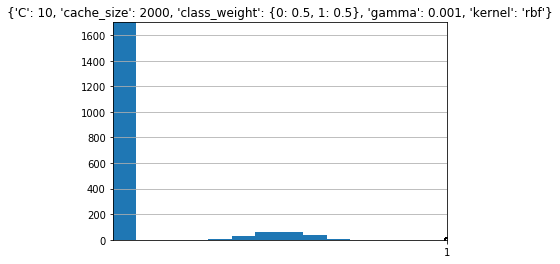

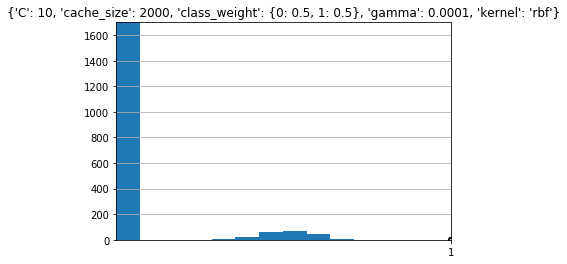

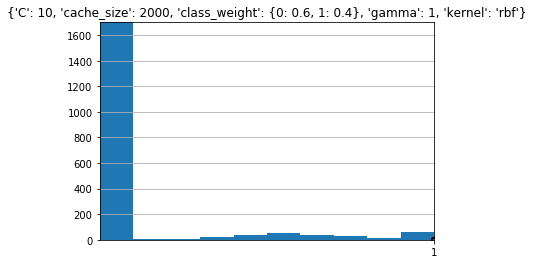

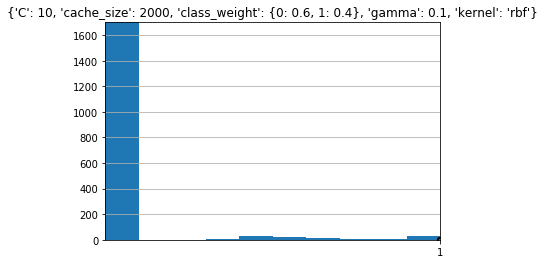

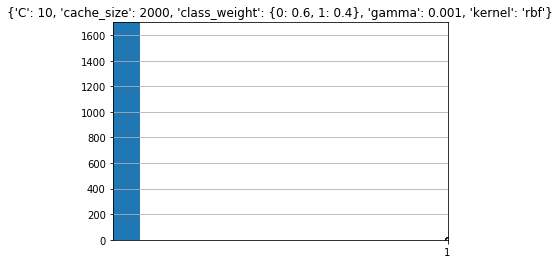

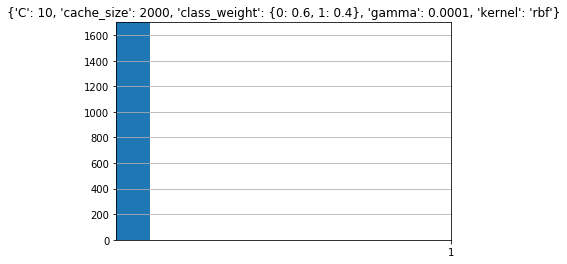

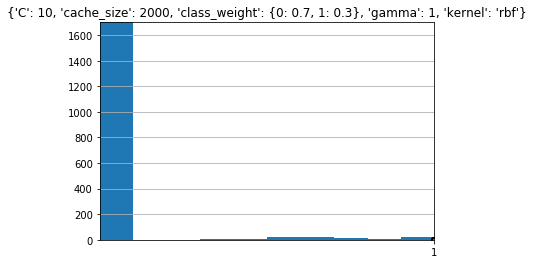

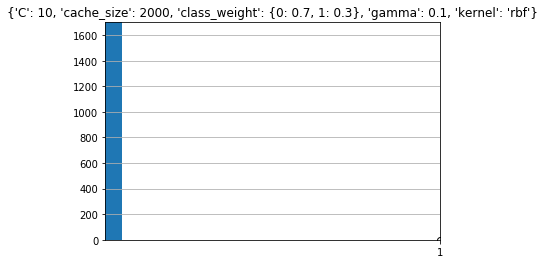

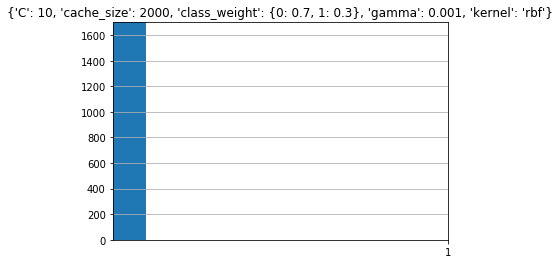

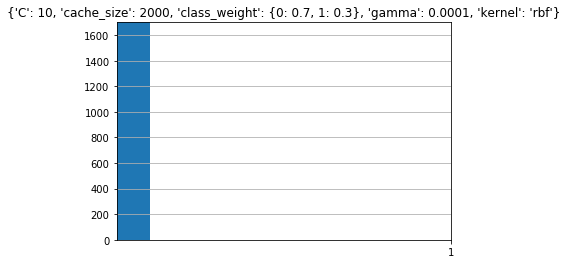

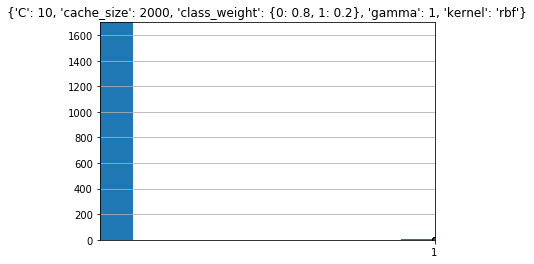

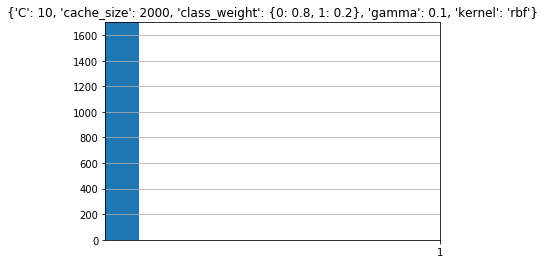

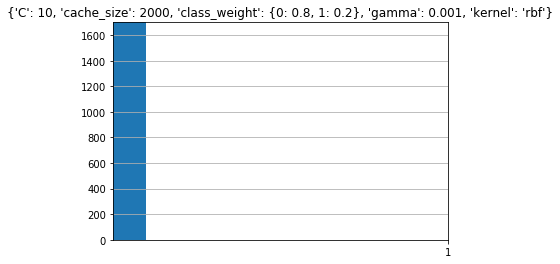

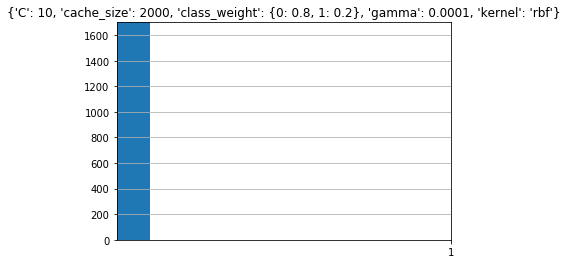

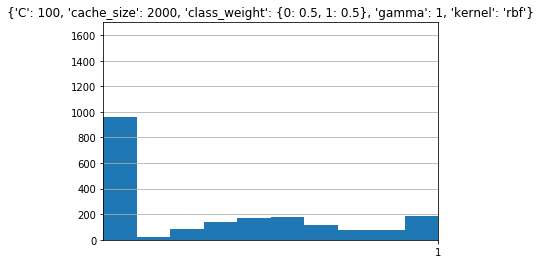

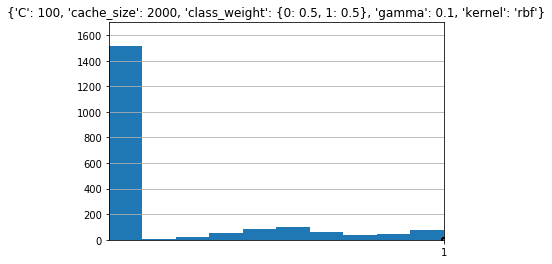

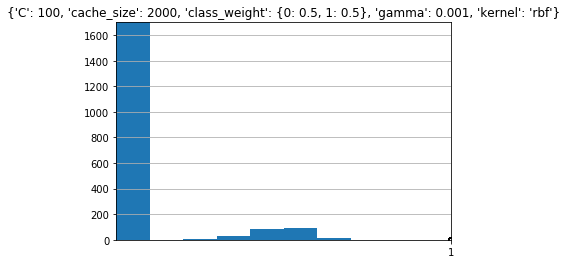

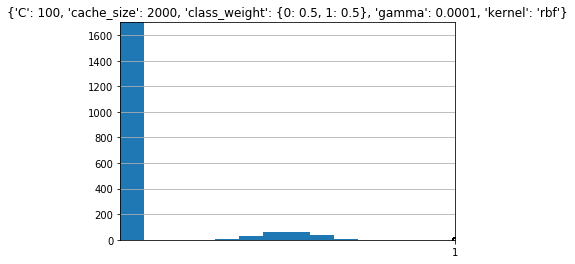

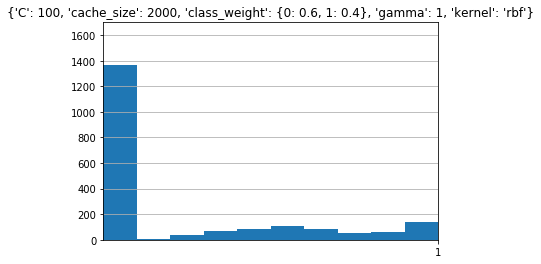

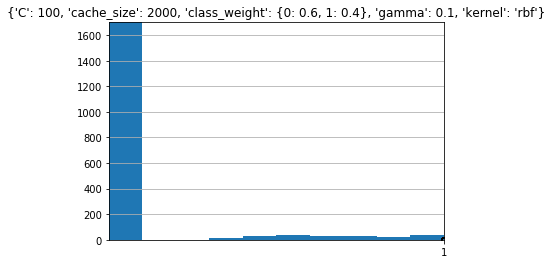

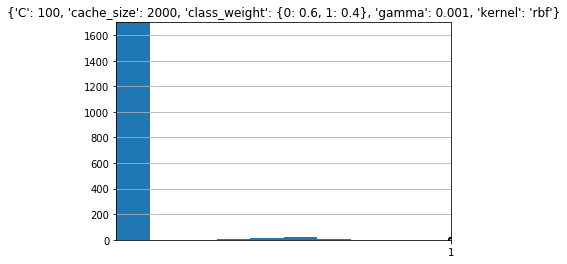

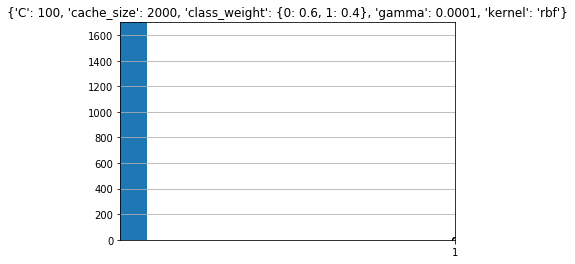

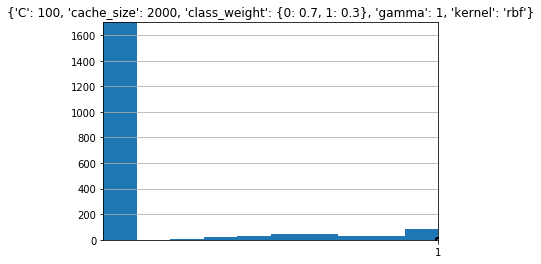

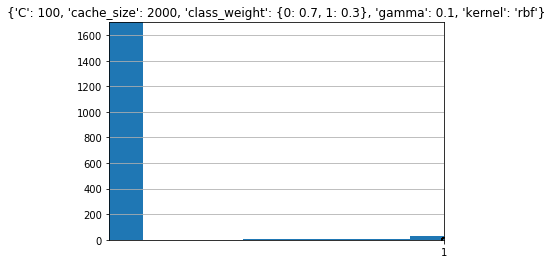

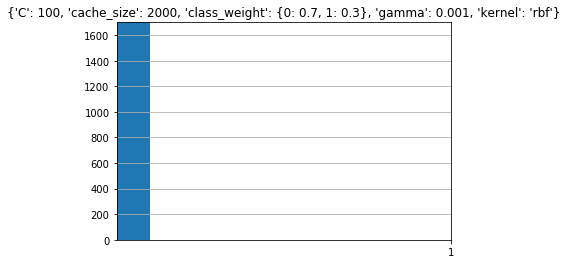

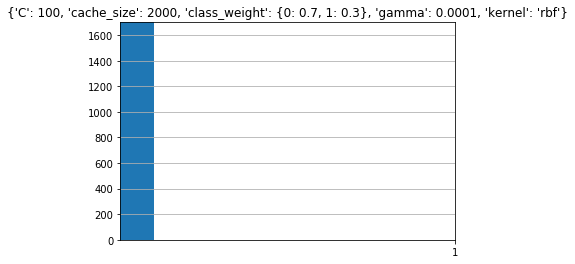

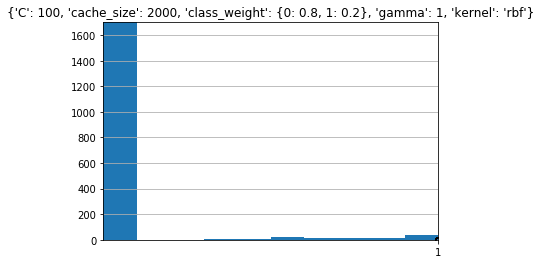

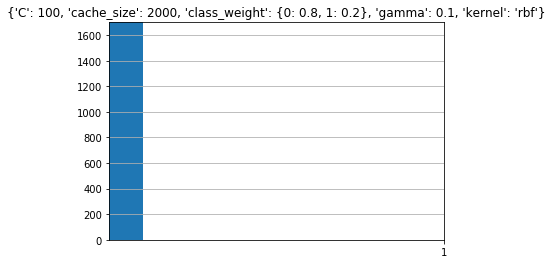

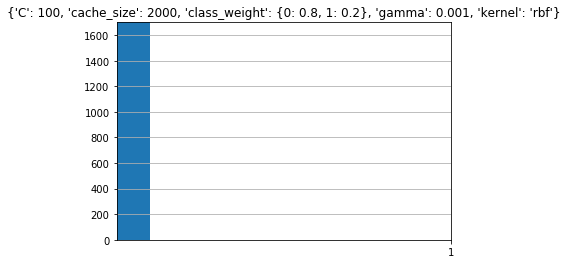

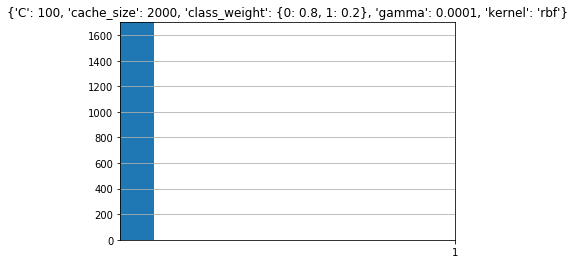

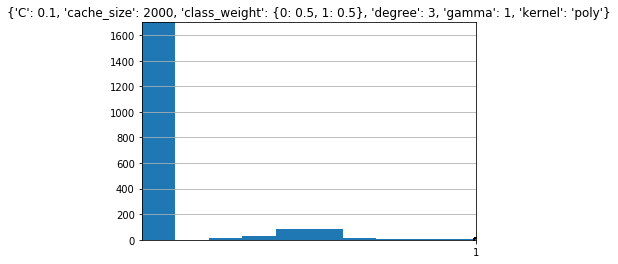

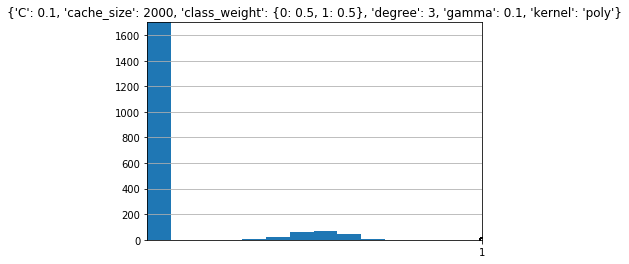

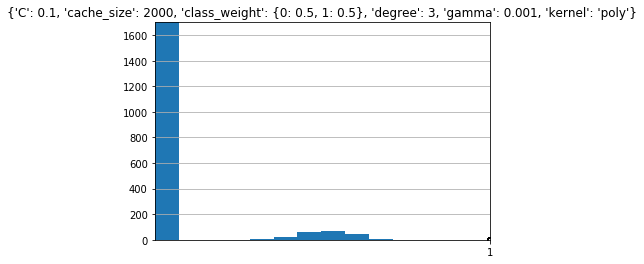

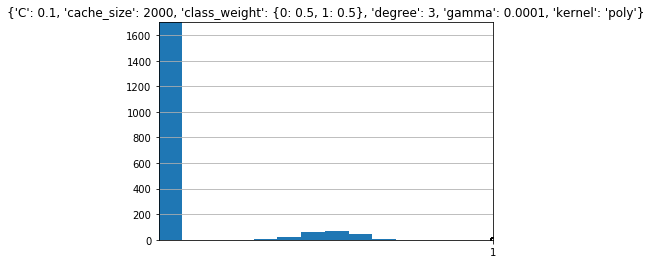

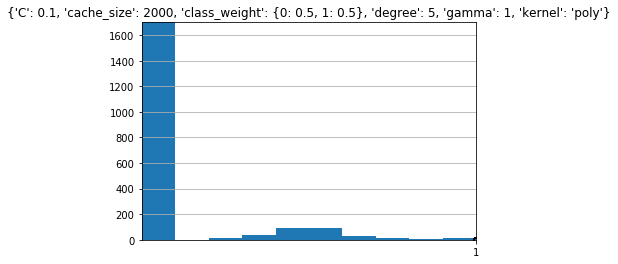

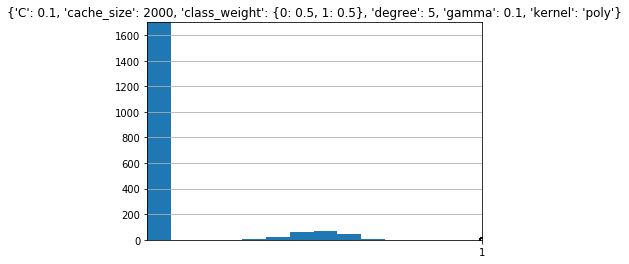

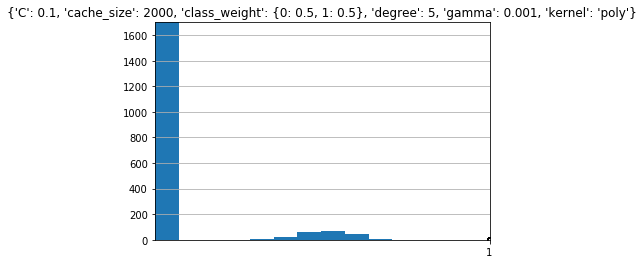

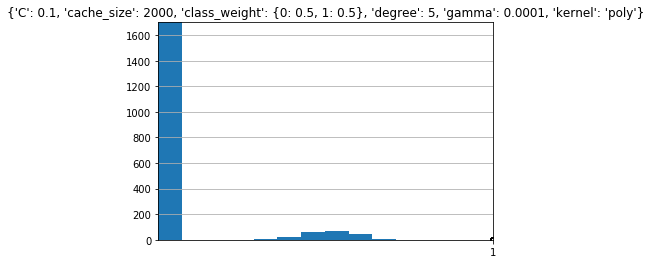

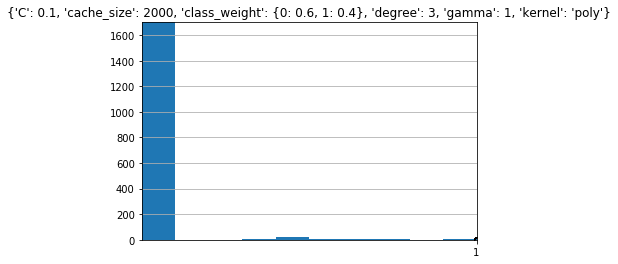

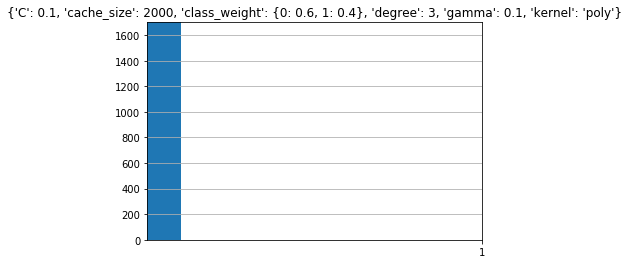

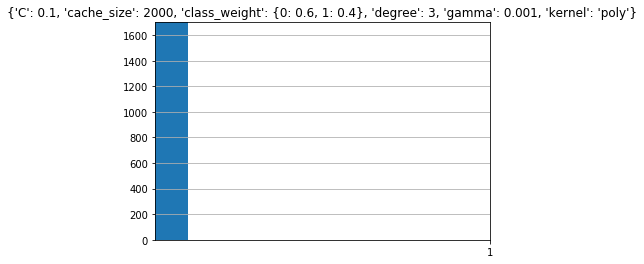

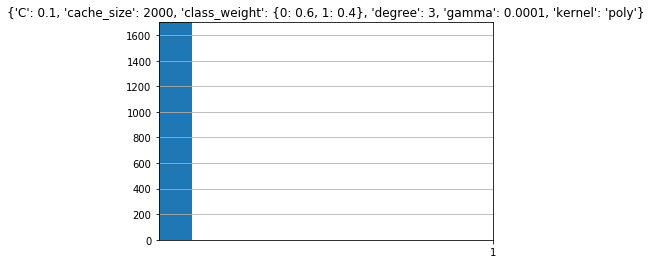

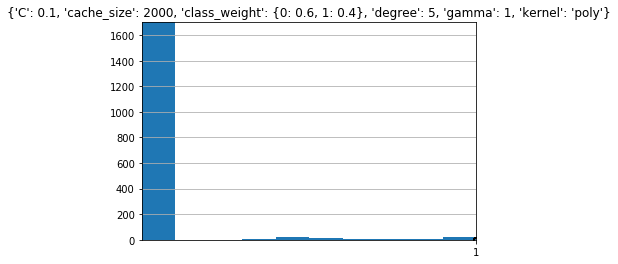

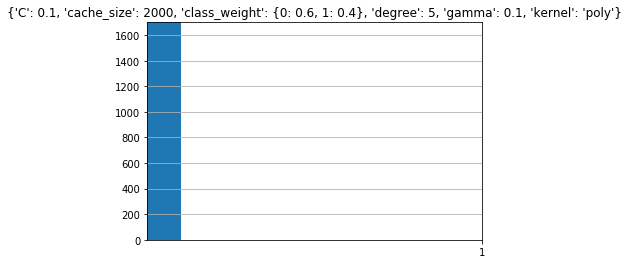

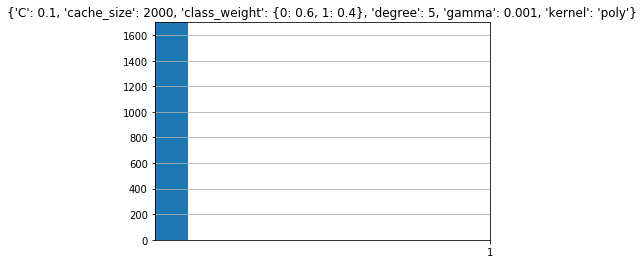

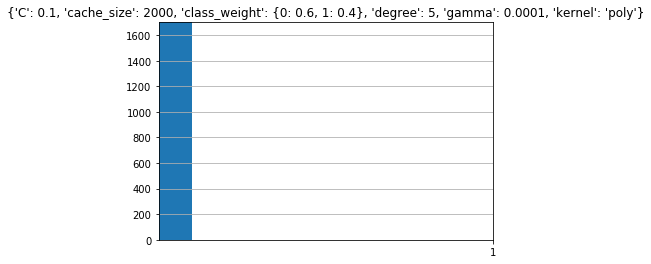

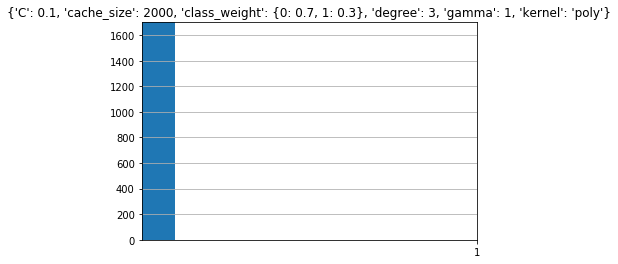

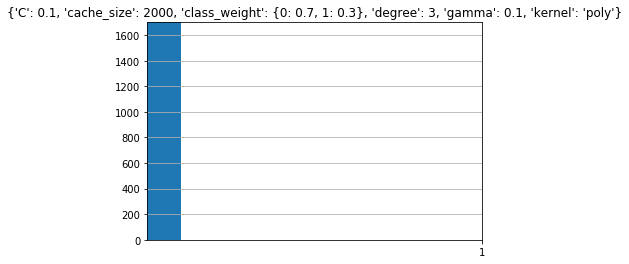

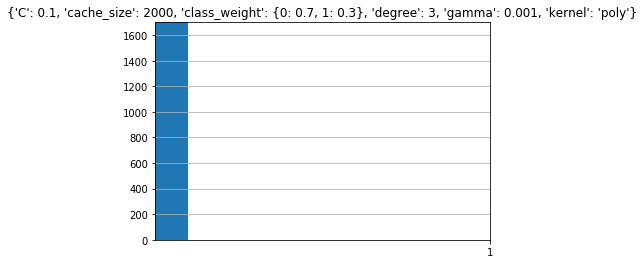

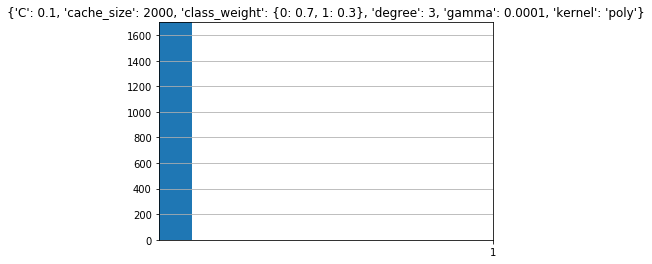

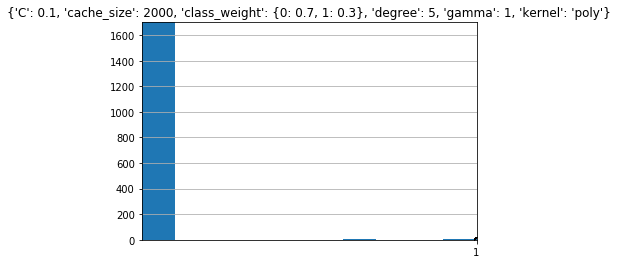

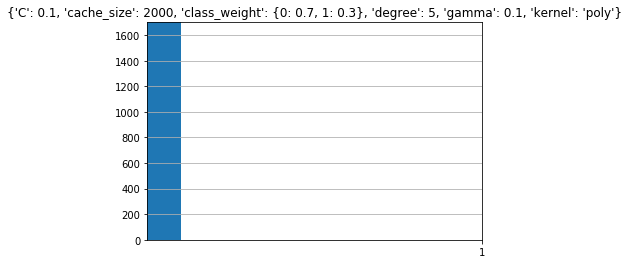

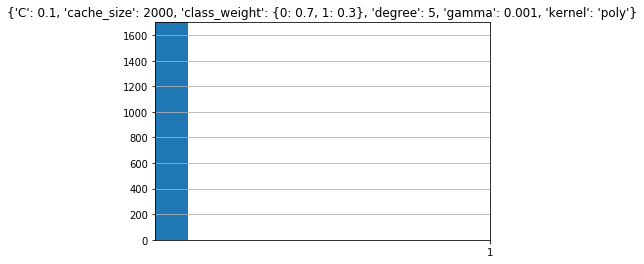

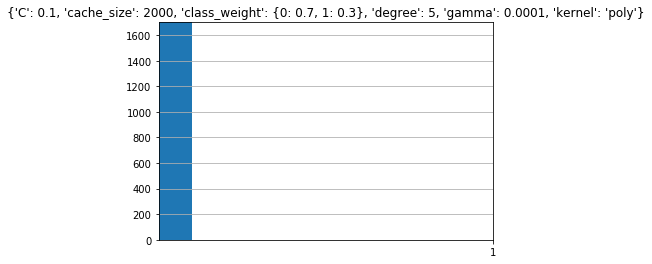

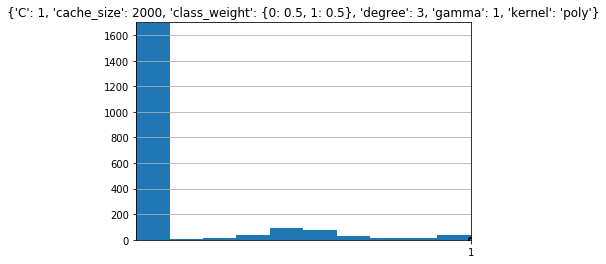

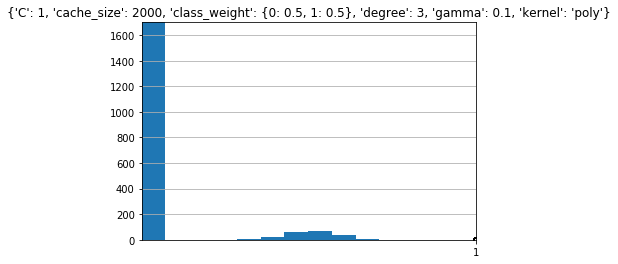

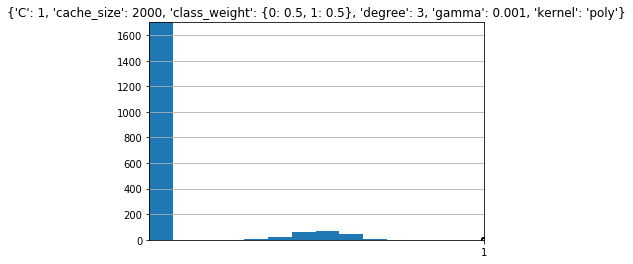

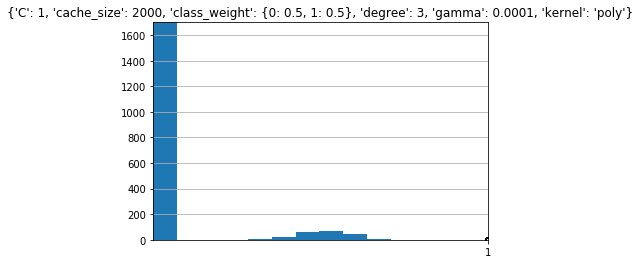

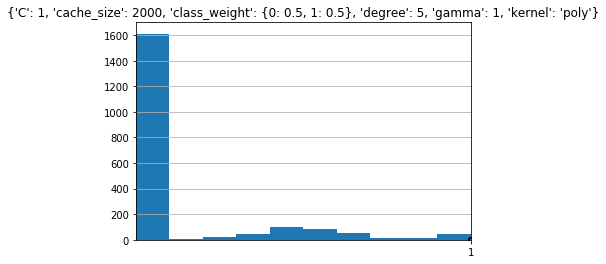

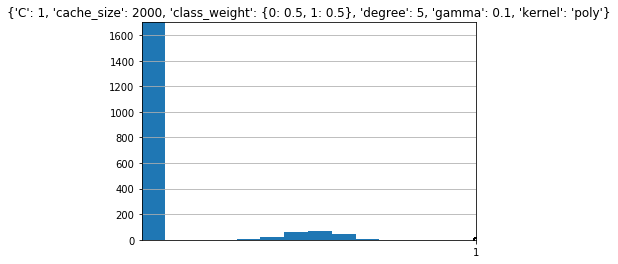

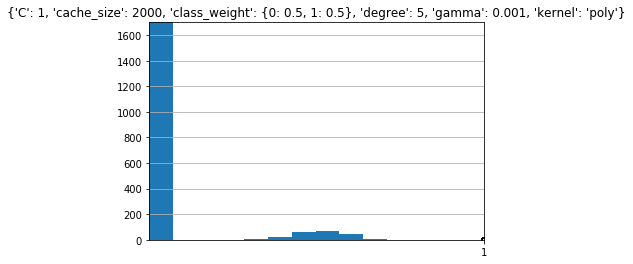

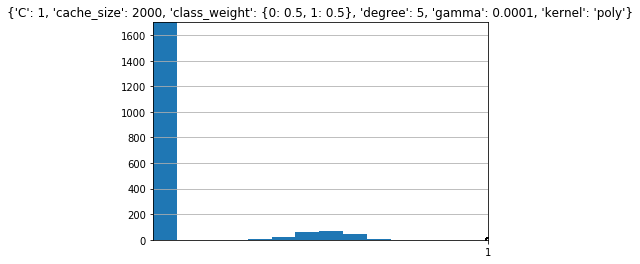

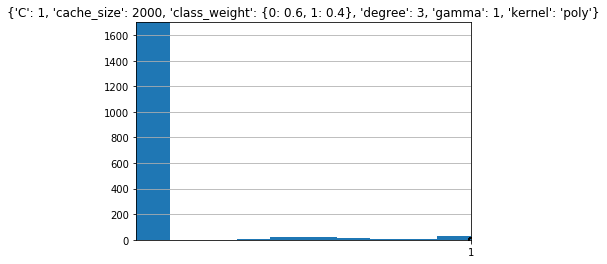

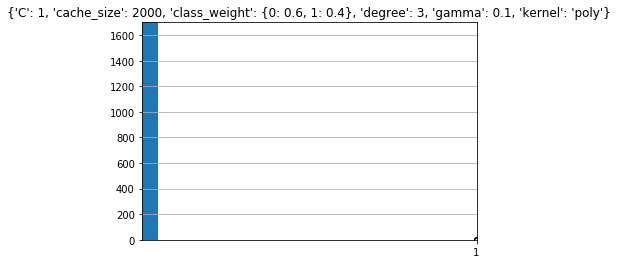

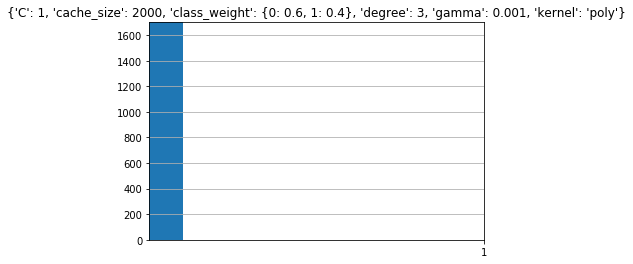

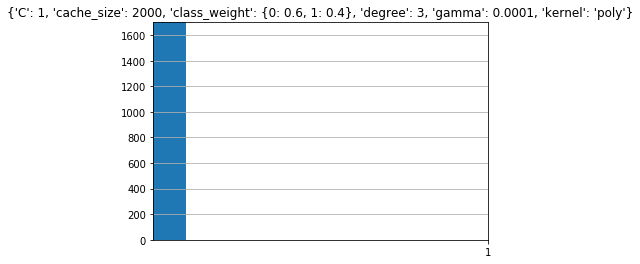

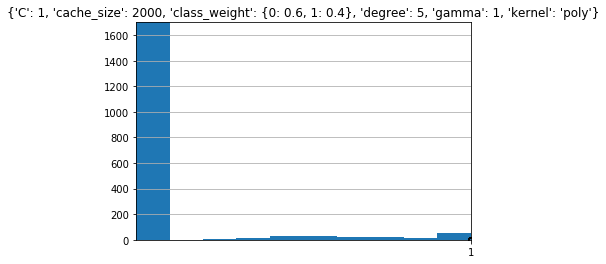

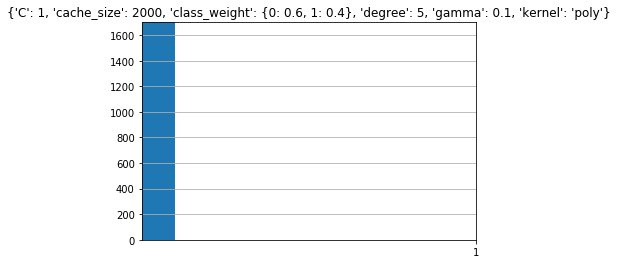

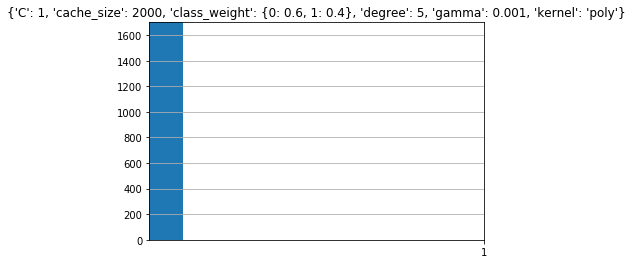

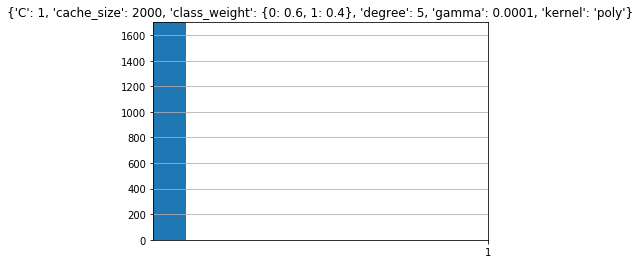

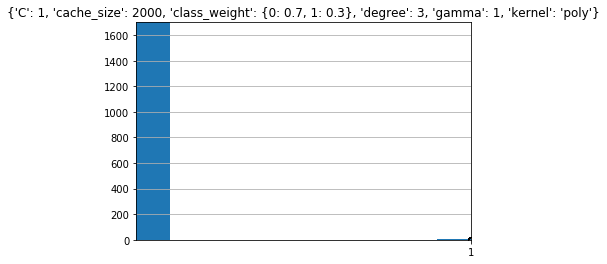

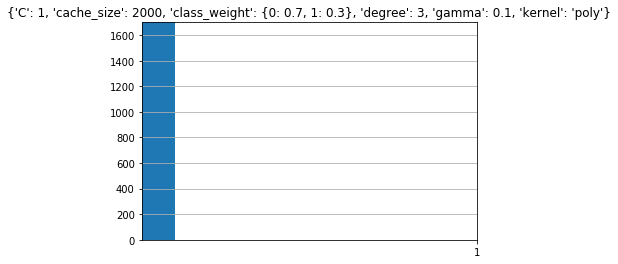

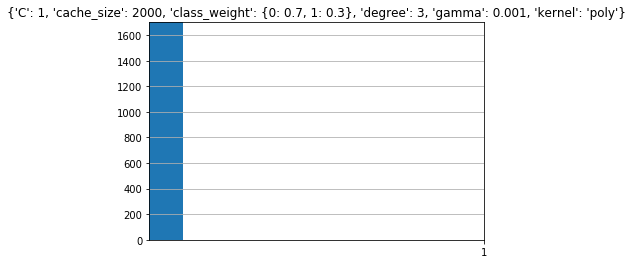

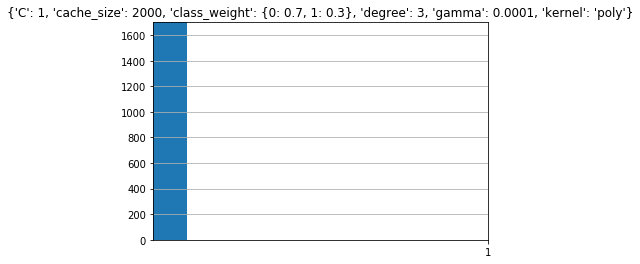

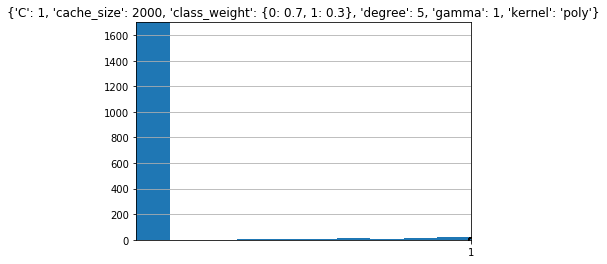

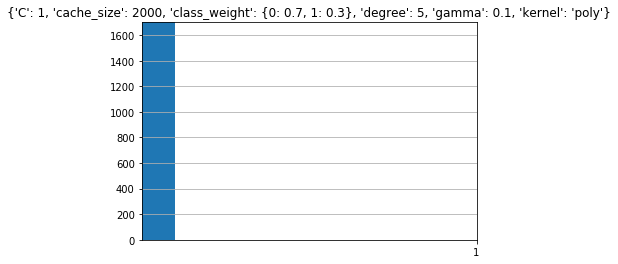

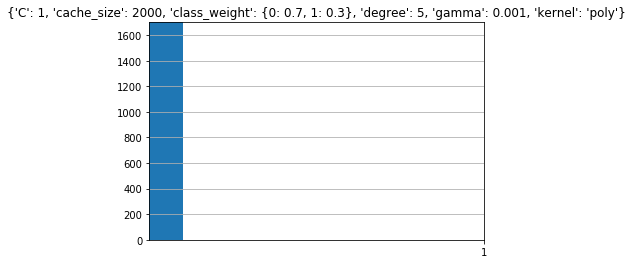

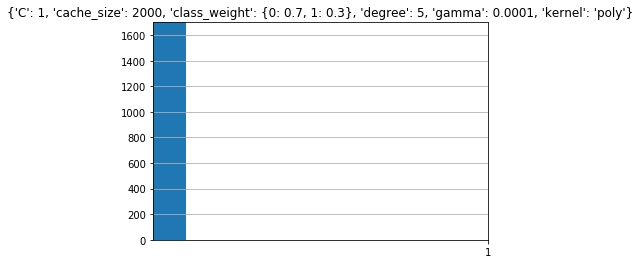

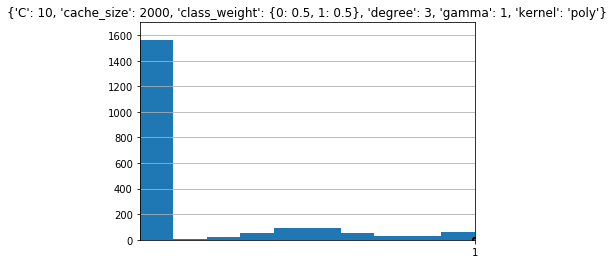

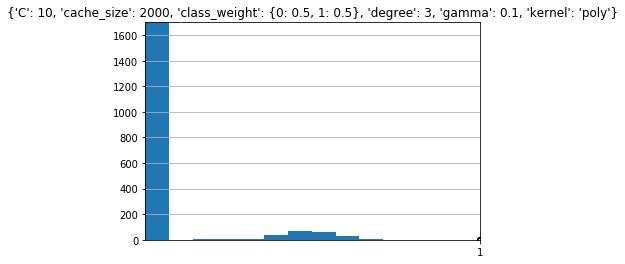

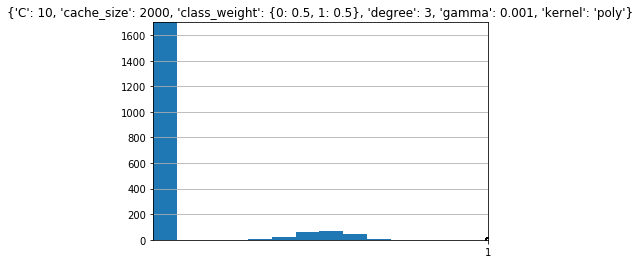

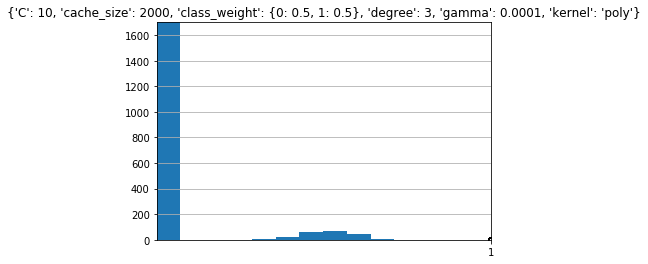

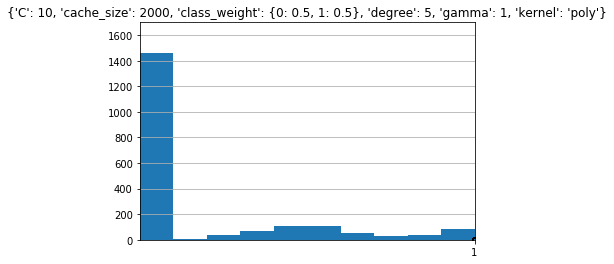

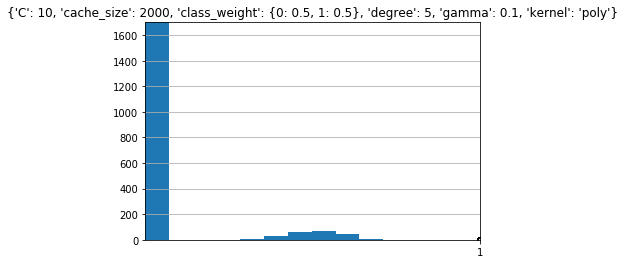

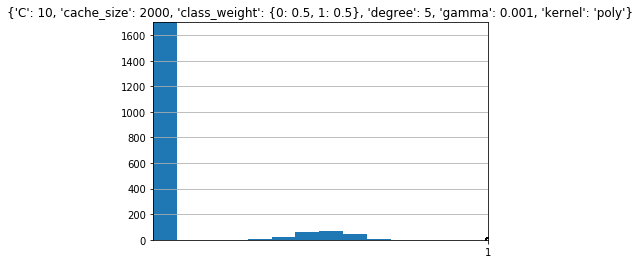

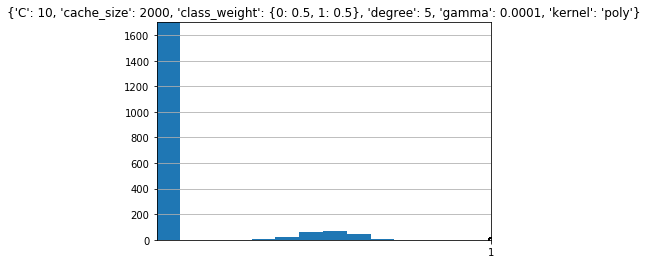

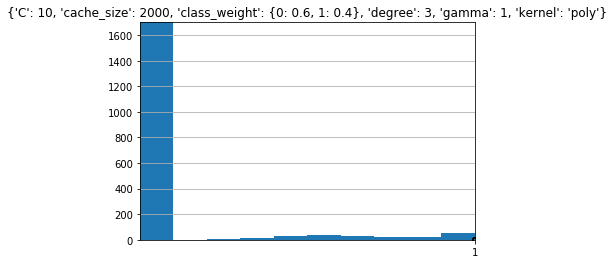

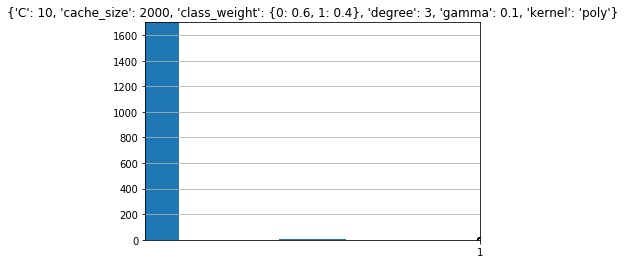

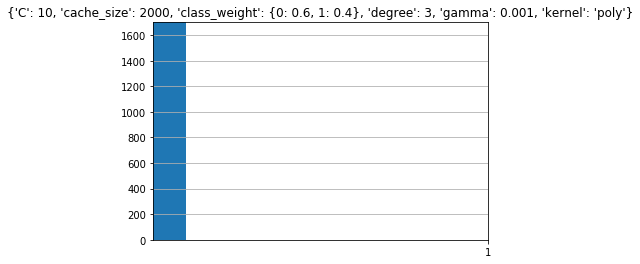

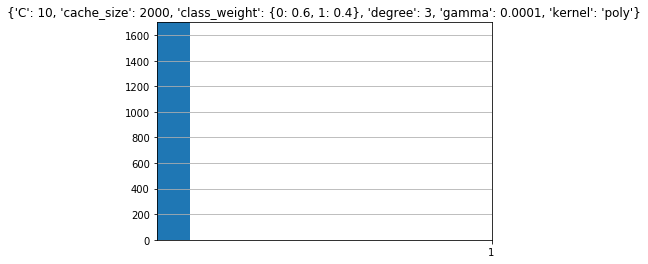

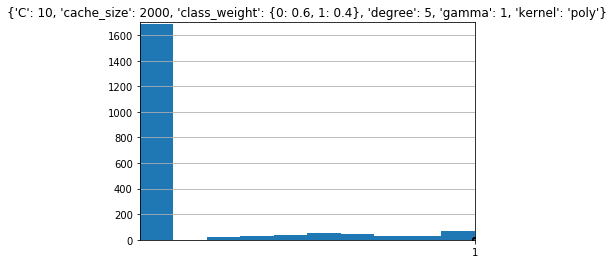

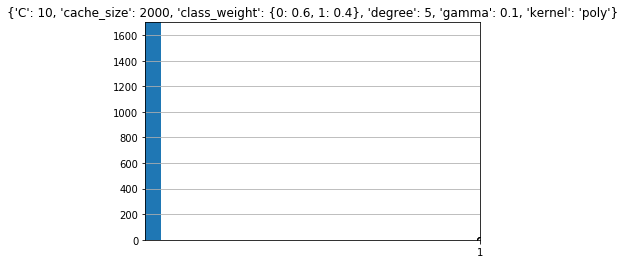

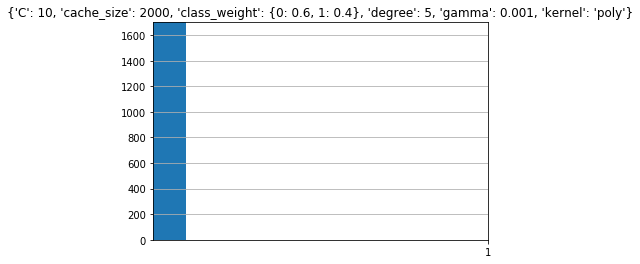

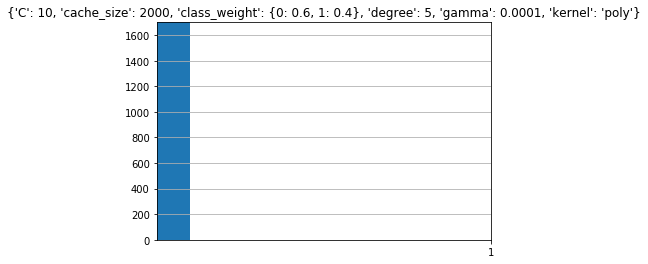

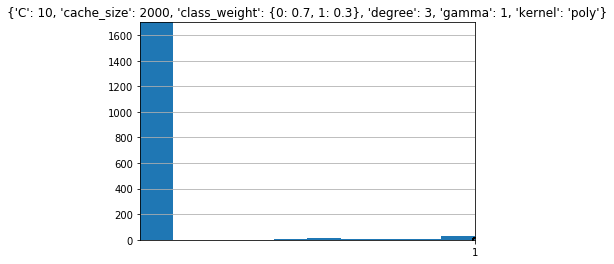

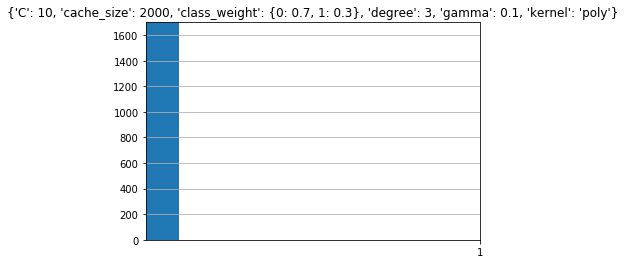

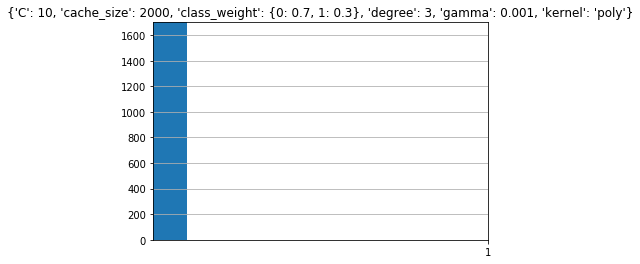

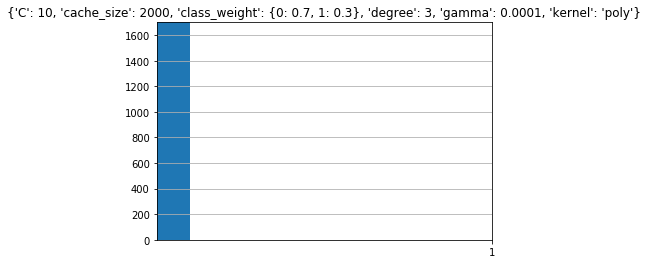

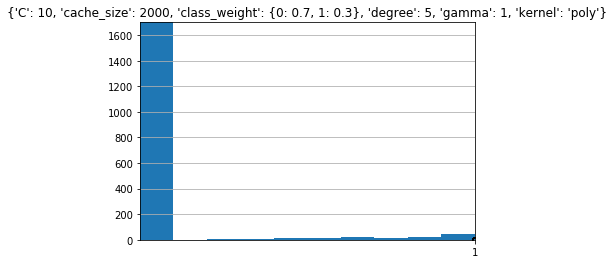

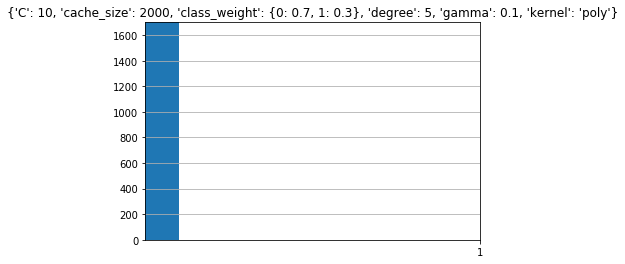

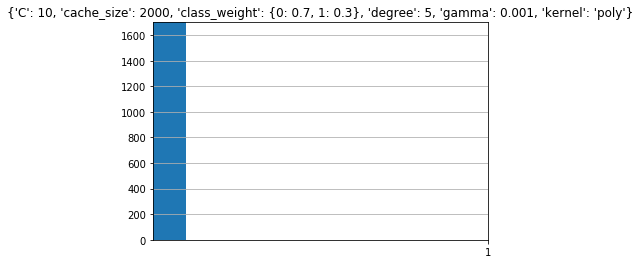

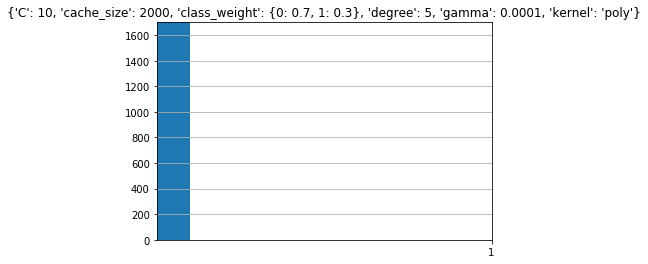

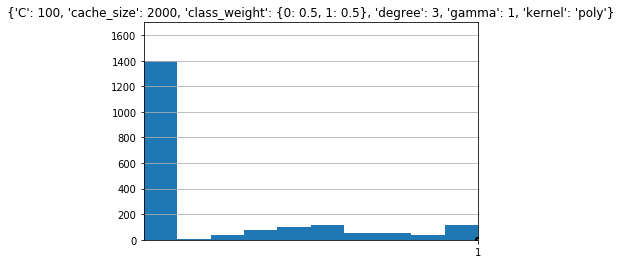

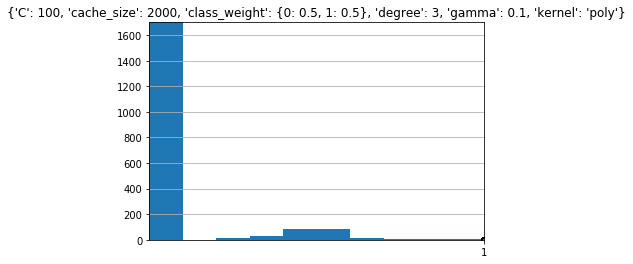

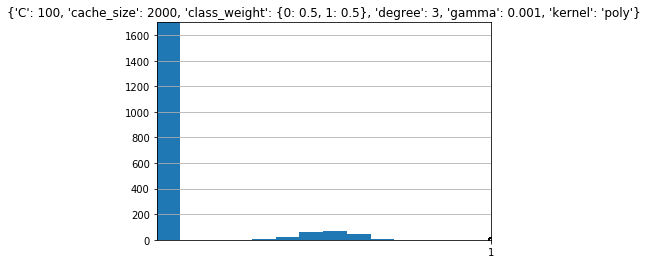

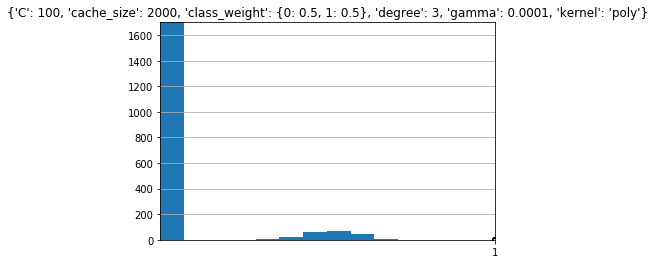

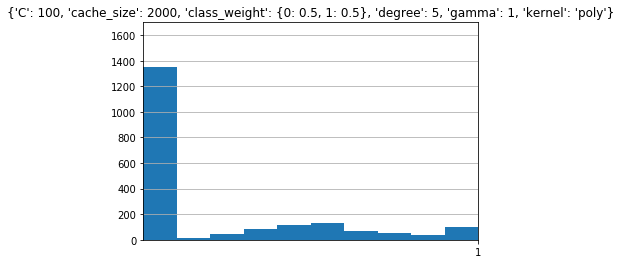

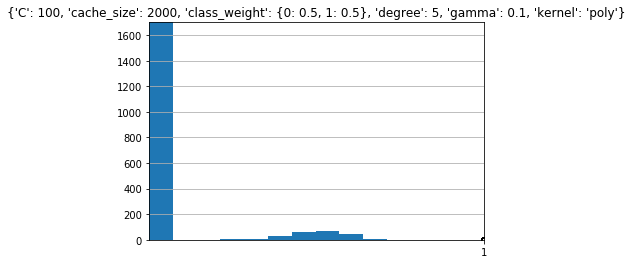

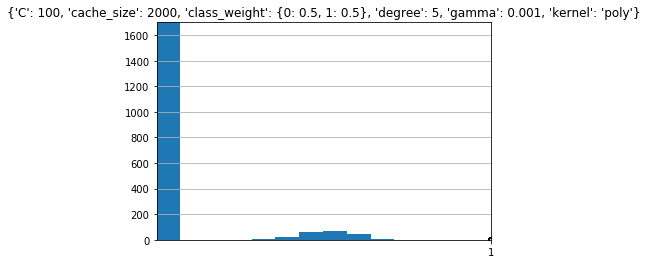

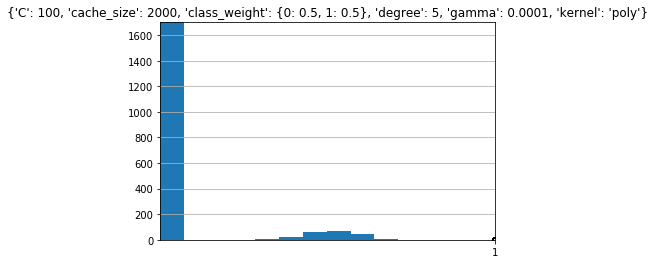

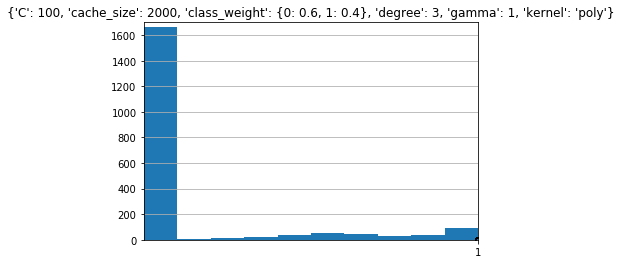

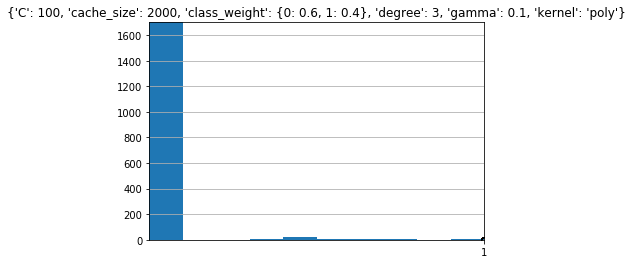

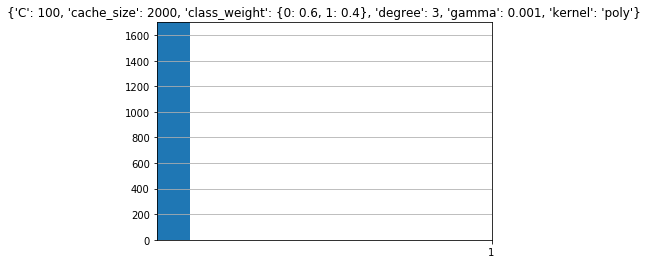

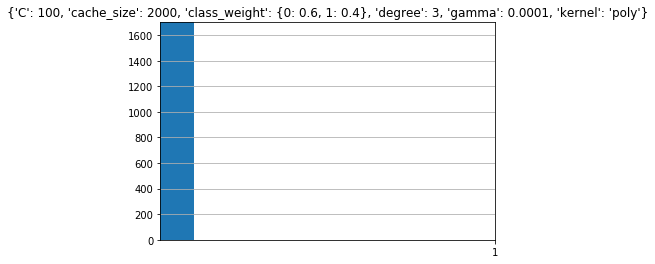

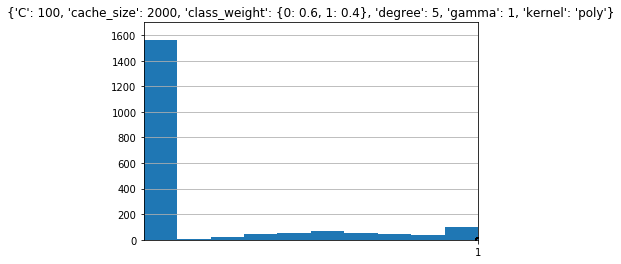

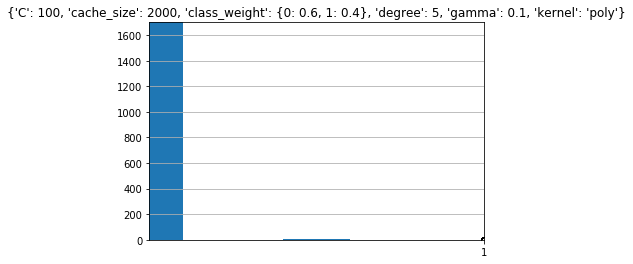

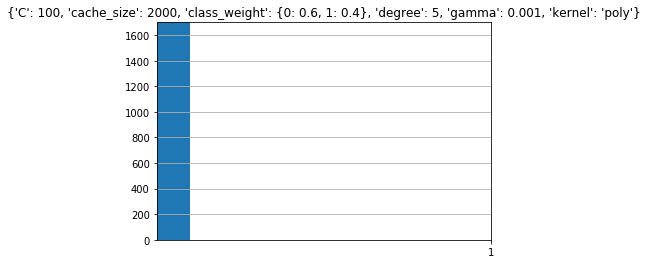

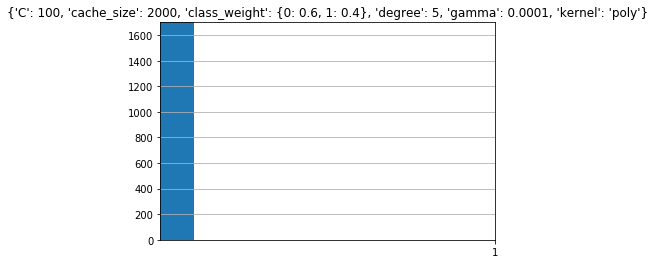

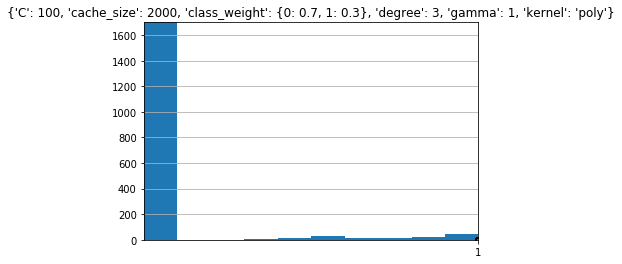

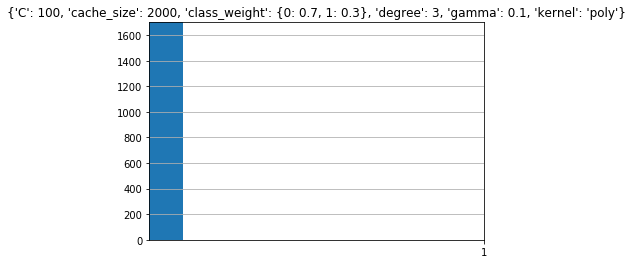

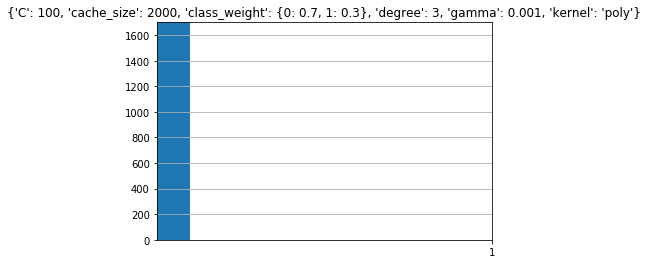

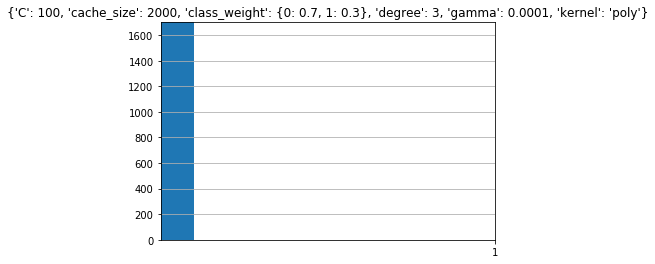

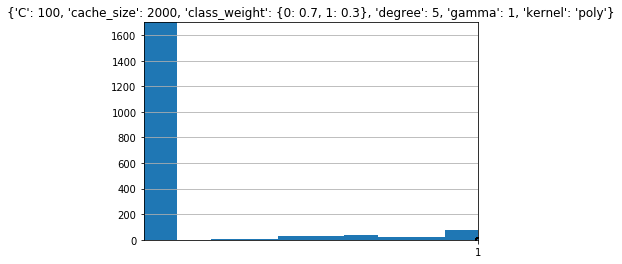

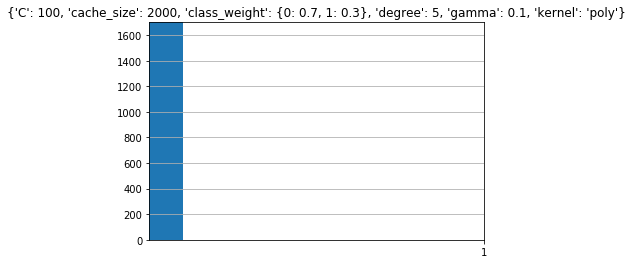

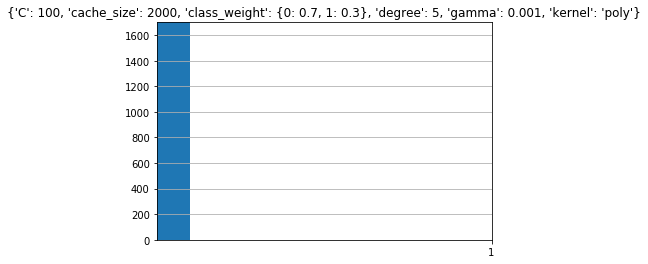

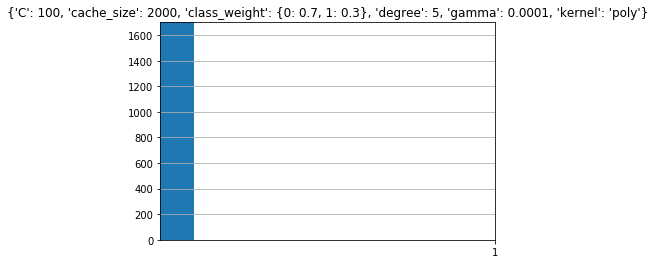

In [248]:
avg_precs = []
for col in prec_recs:
    a = prec_recs[col]
    b = a[a> 0]
    avg_precs.append(np.mean(b))
    plt.figure()
    plt.boxplot(a)
    plt.hist(a, bins=10)
    plt.xlim([0, 1])
    plt.ylim([0, 1700])
    plt.title(gridcv.cv_results_['params'][int(col)])
    plt.grid()
    


In [249]:
prec_rec_lists = [prec_recs[i] for i in prec_recs.columns]

In [250]:
a = [np.sum(x) for x in prec_rec_lists]

In [251]:
best_models = [(idx, gridcv.cv_results_['params'][x]) for idx, x in enumerate(np.argsort(a)[::-1])]

In [252]:
best_models

[(0,
  {'C': 100,
   'cache_size': 2000,
   'class_weight': {0: 0.5, 1: 0.5},
   'gamma': 1,
   'kernel': 'rbf'}),
 (1,
  {'C': 100,
   'cache_size': 2000,
   'class_weight': {0: 0.6, 1: 0.4},
   'gamma': 1,
   'kernel': 'rbf'}),
 (2,
  {'C': 100,
   'cache_size': 2000,
   'class_weight': {0: 0.5, 1: 0.5},
   'degree': 5,
   'gamma': 1,
   'kernel': 'poly'}),
 (3,
  {'C': 100,
   'cache_size': 2000,
   'class_weight': {0: 0.5, 1: 0.5},
   'degree': 3,
   'gamma': 1,
   'kernel': 'poly'}),
 (4,
  {'C': 10,
   'cache_size': 2000,
   'class_weight': {0: 0.5, 1: 0.5},
   'gamma': 1,
   'kernel': 'rbf'}),
 (5,
  {'C': 10,
   'cache_size': 2000,
   'class_weight': {0: 0.5, 1: 0.5},
   'degree': 5,
   'gamma': 1,
   'kernel': 'poly'}),
 (6,
  {'C': 100,
   'cache_size': 2000,
   'class_weight': {0: 0.5, 1: 0.5},
   'gamma': 0.1,
   'kernel': 'rbf'}),
 (7,
  {'C': 100,
   'cache_size': 2000,
   'class_weight': {0: 0.6, 1: 0.4},
   'degree': 5,
   'gamma': 1,
   'kernel': 'poly'}),
 (8,
  {'C':

In [253]:

for i in best_models:

SyntaxError: unexpected EOF while parsing (<ipython-input-253-faf183ddb36b>, line 2)

In [ ]:
best_model = gridcv.cv_results_['params'][0]
best_model

# Backtesting Models

### Dask Parallelization

In [558]:
import dask.dataframe as dd
import dask.delayed
from sklearn.externals import joblib
from sklearn.utils import Parallel

In [572]:
client = Client()

/home/alex/.conda/envs/analysis/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [568]:
?joblib.parallel_backend

In [577]:
parallel = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
                            pre_dispatch=self.pre_dispatch)

NameError: name 'Parallel' is not defined

In [575]:
with joblib.parallel_backend('dask', n_jobs=-1, verbose=10, max_nbytes=2000):
    
    def apply_model(params, info_dict):
        """
        Backtesting. 

        :params: Model Hyperparameters
        :info_dict: Associated Info Dict
        """
        preds = []
        for i in info_dict:
            b_svm = svm.SVC(**params)
            b_svm.fit(i['train']['df_scale'], i['train']['labels'])
            pred = b_svm.predict(i['test']['df_scale'])
            preds.append(pred)
        return np.array(preds)

    preds = apply_model(best_models[0][1], info)

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting

KeyboardInterrupt: 

In [532]:
df_dask = dd.read_csv(save_dir + 'df.csv', blocksize=50e6)

In [533]:
df_dask

,Unnamed: 0,0,1,2,3,4
npartitions=9,,,,,,
,int64,float64,float64,float64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [549]:
def apply_model_dd(params, info_dict):
    """
    Backtesting. 
    
    :params: Model Hyperparameters
    :info_dict: Associated Info Dict
    """
    preds = []
    for i in info_dict:
        b_svm = dask.delayed(svm.SVC)(**params)
        dask.delayed(b_svm.fit)(i['train']['df_scale'], i['train']['labels'])
        pred = dask.delayed(b_svm.predict)(i['test']['df_scale'])
        preds.append(pred)
    return np.array(preds)

In [550]:
f_preds = dask.compute(apply_model_dd(best_models[0][1], info))

In [551]:
f_preds

(array([Delayed('predict-22d59b0a-49ab-47ff-9ab2-7c1c46197dc6'),
        Delayed('predict-61d482e1-ccc7-4634-9b3f-482067c3ed80'),
        Delayed('predict-518d2dae-db14-4509-a271-21d1574b54b3'), ...,
        Delayed('predict-2b26bee1-ffa3-480c-b7e5-7509ffecabbf'),
        Delayed('predict-6a77aa37-ecb9-4055-9bd3-b2d232d745d4'),
        Delayed('predict-77e8d2eb-7366-4ae1-a4f0-b17811e3292a')],
       dtype=object),)

# Normal Backtesting

In [186]:
def apply_model(params, info_dict):
    """
    Backtesting. 
    
    :params: Model Hyperparameters
    :info_dict: Associated Info Dict
    """
    preds = []
    for i in info_dict:
        b_svm = svm.SVC(**params)
        b_svm.fit(i['train']['df_scale'], i['train']['labels'])
        pred = b_svm.predict(i['test']['df_scale'])
        preds.append(pred)
    return np.array(preds)


In [187]:
preds = apply_model(best_models[0][1], info)

In [188]:
f_preds = np.hstack(preds)

In [190]:
precision(f_preds, df_test_only['label'])

ValueError: operands could not be broadcast together with shapes (199447,) (201447,) 

In [ ]:
?cm

In [ ]:
backtest(f_preds, df_test_only)

In [ ]:
len(trade_profit_timeline)

In [ ]:
sum(profit_timeline)

In [ ]:
plt.figure()
plt.plot(np.cumsum(profit_timeline), color='green')
plt.xlabel('Time')
plt.ylabel('P/L')
plt.grid()

In [ ]:
plt.figure()
plt.hist(time_held_timeline, bins=5, linestyle='solid', edgecolor='black')
plt.xlabel('Minutes held')
plt.ylabel('Frequency')

In [ ]:
plt.figure()
plt.scatter(time_held_timeline, trade_profit_timeline)

In [ ]:
plt.figure()
plt.boxplot(profit_timeline)
plt.ylabel('P/L per trade')

In [ ]:
plt.figure()
np.mean(trade_profit_timeline)

In [ ]:
## Sharpe

np.mean(profit_timeline)/np.std(profit_timeline)

In [ ]:
np.mean(profit_timeline)
np.std(profit_timeline)

In [ ]:
df_temp = df_test_only.copy()
df_temp['profit_timeline'] = profit_timeline

In [ ]:
df_temp

In [ ]:
df_temp['profit_timeline_returns'] = profit_timeline/(df_temp.GOOG + df_temp['beta*GOOGL'])

In [ ]:
np.mean(df_temp['profit_timeline_returns']-2.6/np.sqrt(252*60))/np.std(df_temp['profit_timeline_returns'])

In [729]:
(1+0.026/252)**(252)

1.0263395719688697

In [701]:
daily_profit = df_temp.groupby(by = [df_temp.TIMESTAMP.dt.year, df_temp.TIMESTAMP.dt.month, df_temp.TIMESTAMP.dt.day])['profit_timeline'].sum()

In [745]:
np.mean(profit_timeline)


0.02344122409909444

In [746]:
np.std(profit_timeline)

0.26871049635513233

In [743]:
print('Sharpe Ratio')
np.mean(daily_profit)/np.std(daily_profit) * np.sqrt(252)

Sharpe Ratio


12.594141016270271

In [741]:
print('Sortino Ratio')
np.mean(daily_profit)/np.std([x for x in daily_profit if x < 0])

Sortino Ratio


9.462489798773303

In [707]:
np.sqrt(2.6/252)

0.101574900036674

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

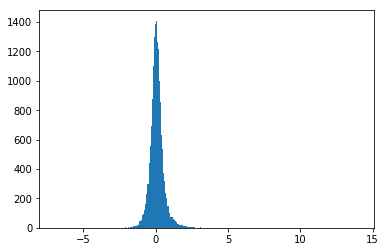

In [708]:
plt.hist(trade_profit_timeline, bins=1000)

In [709]:
np.median(trade_profit_timeline)

0.054808081491728444

### We need to find a way to combine this dataset into one large dataset for the sake of multithreading ease with gridsearchcv

In [504]:
splits.shape

(2015, 2)

In [ ]:
splits[0]

In [ ]:
np.bincount(multi_cv_labels)

In [ ]:
pd.DataFrame(precs).T

In [ ]:
np.save('./results/2019_01_06_2000_100_rbf_results/cv_results/results.npy', results)
np.save('./results/2019_01_06_2000_100_rbf_results/cv_results/info.npy', info)

In [ ]:
# t_score = np.abs(t_score)
# results = {}
# for i in range(len(info)):
#     train = info[i]['train']['df_scale']
#     train_labels = info[i]['train']['labels']

#     test = info[i]['test']['df_scale']
#     test_labels = info[i]['test']['labels']

#     train_idx = train.shape[0]
#     test_idx = test.shape[0]
    
#     split = [(np.arange(train_idx), np.arange(train_idx, train_idx+test_idx))]
#     final = pd.concat([train, test], ignore_index=True)
#     final_labels = train_labels.append(test_labels)
#     gridcv = GridSearchCV(svm.SVC(), models, verbose=10, cv=split, n_jobs=-1, 
#                         scoring=['precision'], refit=False)
#     gridcv.fit(final, final_labels)
    
#     results[i] = {'results': gridcv.cv_results_, 'grid': gridcv}



In [ ]:
gridcv.cv_results_

In [ ]:
for k, v

In [ ]:
for k, v in results.items():
    idx = np.argmax(v['results']['mean_test_precision'])
    print(v['grid'].cv_results_['params'][idx])
    print(v['results']['mean_train_precision'][idx])

In [ ]:
# splits = []
# multi_cv_df = pd.DataFrame()
# multi_cv_labels = pd.Series()

# for i in range(len(info)):
#     train = info[i]['train']['df_scale'].copy()
#     train_labels = info[i]['train']['labels'].copy()
    
#     mod_index_train = np.array([str(i) + '_' + str(idx) for idx in train_labels.index])
#     train.index = mod_index_train
#     train_labels.index = mod_index_train
    
#     test = info[i]['test']['df_scale'].copy()
#     test_labels = info[i]['test']['labels'].copy()

#     mod_index_test = np.array([str(i) + '_' + str(idx) for idx in test_labels.index])
#     test.index = mod_index_test
#     test_labels.index = mod_index_test
    
    
#     train_len = train.shape[0]
#     test_len = test.shape[0]
    
#     splits.append((mod_index_train, mod_index_test))
    
#     multi_cv_df = multi_cv_df.append(train)
#     multi_cv_labels = multi_cv_labels.append(train_labels)
    
#     multi_cv_df = multi_cv_df.append(test)
#     multi_cv_labels = multi_cv_labels.append(test_labels)

# #     assert(np.array_equal(multi_cv_df.loc[splits[i][0]].values, train.values))
# #     assert(np.array_equal(multi_cv_labels.loc[splits[i][0]].values, train_labels.values))
# #     assert(np.array_equal(multi_cv_df.loc[splits[i][1]], test.values))
# #     assert(np.array_equal(multi_cv_labels.loc[splits[i][1]], test_labels))

#     if i == 0:
#         break
# splits = np.array(splits)

# Best performing Models: 




In [ ]:
results

In [ ]:
models = [

{'C': 100, 'cache_size': 2000, 'class_weight': {0: 0.5, 1: 0.5}, 'gamma': 1, 'kernel': 'rbf'}, 
{'C': 100, 'cache_size': 2000, 'class_weight': {0: 0.6, 1: 0.4}, 'gamma': 1, 'kernel': 'rbf'}, 
{'C': 10, 'cache_size': 2000, 'class_weight': {0: 0.6, 1: 0.4}, 'gamma': 1, 'kernel': 'rbf'}, 
{'C': 1, 'cache_size': 2000, 'class_weight': {0: 0.5, 1: 0.5}, 'gamma': 1, 'kernel': 'rbf'}, 
    
# {'C': 100, 'cache_size': 2000, 'class_weight': {0: 0.5, 1: 0.5}, 'degree': 5, 'gamma': 1, 'kernel': 'poly'}, 
# {'C': 100, 'cache_size': 2000, 'class_weight': {0: 0.7, 1: 0.3}, 'degree': 5, 'gamma': 1, 'kernel': 'poly'}, 
# {'C': 100, 'cache_size': 2000, 'class_weight': {0: 0.6, 1: 0.4}, 'degree': 5, 'gamma': 1, 'kernel': 'poly'}, 
    
# {'C': 1, 'cache_size': 2000, 'class_weight': {0: 0.5, 1: 0.5}, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}, 
# {'C': 1, 'cache_size': 2000, 'class_weight': {0: 0.5, 1: 0.5}, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}, 
    
]

In [ ]:
model_results = [[] for m in models]
for k, v in results.items():
    for num, i in enumerate(models):
        idx = v['grid'].cv_results_['params'].index(i)
        model_results[num].append(v['results']['mean_test_precision'][idx])

In [ ]:
len(model_results)

In [ ]:
plt.figure(figsize=(8, 8))
str_models = [str(i) for i in models]
for i, model in enumerate(str_models):
    plt.figure()
    plt.title(model)
    plt.hist(model_results[i])
plt.legend()

In [ ]:
[np.mean(x) for x in model_results]

In [ ]:
def backtest()

In [ ]:
for model in model_results:
    a = np.array(model.copy())
    print(a[a > 0].mean())
    

In [ ]:
b = np.array(model_results[0].copy())

b[b > 0].mean()

In [ ]:
import pickle

### How much money can you even make

In [ ]:
x = pd.DataFrame()
x['goog'] = df_gg['CLOSE'][0:1999]
x['googl'] = df_ggl['CLOSE'][0:1999]
x['label'] = info[0]['train']['labels']
x['residual'] = info[0]['train']['residuals_fit_price']

In [ ]:
info[0]['train']['index']

In [ ]:
beta = info[0]['train']['beta_fit_price']
beta

In [ ]:
plt.plot(x['googl'] - info[0]['train']['beta_fit_price'] * x['goog'])

In [ ]:
x['hedge_googl'] = beta*x['googl']
x['diff_googl'] = x['hedge_googl']-x['hedge_googl'].shift(1)
x['diff_goog'] = x['goog']-x['goog'].shift(1)
x['profit'] = x['diff_googl'] - x['diff_goog']
x['goog_returns'] = x['goog'].pct_change()
x['googl_returns'] = x['googl'].pct_change()
x['resid_comp'] = x['goog_returns'] - (beta * x['googl_returns'])
x[1900:]

In [ ]:
plt.boxplot(x['residual'])

In [ ]:
x['naive_trade'] = (x['residual'] > 0.001).astype(int)

In [ ]:
np.bincount(x['naive_trade'])

In [ ]:
np.mean(x['goog_returns'] - x['googl_returns'])

In [ ]:
plt.plot(x['residual'], alpha=0.2)
plt.plot(x['hedge_googl'].pct_change(), alpha=0.2)

In [ ]:
df_goog

In [ ]:
results.keys()

In [ ]:
np.argmax(gridcv.cv_results_['mean_test_precision'])

In [ ]:
gridcv.cv_results_['params'][128]

In [ ]:
for i in results.keys():
    print(results[i]['score'])
    print(results[i]['params'])

In [ ]:
## TODO

# Find best param method

In [ ]:
p7 = gridcv.cv_results_['params'][128]
p7

In [ ]:
df7 = info[1]['train']['df_scale']
label7 = info[1]['train']['labels']

In [ ]:
df7t = info[0]['test']['df_scale']
label7t = info[0]['test']['labels']

In [ ]:
svm7 = svm.SVC(**p7)

In [ ]:
svm7.fit(df7, label7)

In [ ]:
test_labels = svm7.decision_function(df7t)

In [ ]:
plt.plot(test_labels)

In [ ]:
test_labels[test_labels >= 0.4] = 1
test_labels[test_labels < 0.4] = 0

In [ ]:
test_labels

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
precision_score(label7t, test_labels)

In [ ]:
plt.plot(label7t)

In [ ]:
plt.plot(roc_curve(label7t, test_labels)[0], roc_curve(label7t, test_labels)[1])

In [ ]:
# Threshold 0.001 window 5 raw t-scores works ok for 1000-300 but still leaves something to be desired

In [ ]:
train_residuals = train['residuals_fit_price']
min_val = train_residuals[::-1].rolling(window=window).min()[::-1]
min_val.iloc[-window:] = train_residuals.iloc[-window:]

a = (train_residuals-min_val) > threshold
train_labels = a.astype(int)

test_residuals = test['residuals_transform_price']
window=5
threshold = 0.001
min_val = test_residuals[::-1].rolling(window=window).min()[::-1]
min_val.iloc[-window:] = test_residuals.iloc[-window:]

b = (test_residuals-min_val) > threshold
test_labels = b.astype(int)

# RESIDUALSPLOT

In [ ]:
plt.plot(x)

In [ ]:
mean = np.mean(x)

In [ ]:
std = np.std(x)

In [ ]:
delta = x[1:]-x.shift(1)[1:]

In [ ]:
z = x[1:][np.abs(delta) > 2*std].loc[:100]

In [ ]:
z.index

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(x[:100])
for i in z.index:
    plt.axvline(i, linestyle='dashed', alpha=0.2)

In [ ]:
plt.boxplot((residuals-min_val)[:-5])

In [ ]:
plt.plot(residuals - min_val)

In [ ]:
residuals

In [ ]:
# img_directory = './train_test_splits/2019_01_06_sliding_plots_1000_100_raw_tscore/plots'
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter

for fold in range(len(info)):
    train = info[fold]['train']['df']
    test = info[fold]['test']['df']
    
    df_view = df_goog.iloc[train.index[0]:test.index[-1]]
    df_viewl = df_googl.iloc[train.index[0]:test.index[-1]]
    
    fig = plt.figure(figsize=(20, 10))
    gridspec.GridSpec(2, 3)

    ax1 = plt.subplot2grid((2, 3), (0, 0))
    train.plot(ax=ax1, alpha=0.5)
    ax1.legend()
    ax1.set_title('Training T-scores; Indices = %d - %d' % (train.index[0], train.index[-1]))
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Absolute Value of T-score')
    ax1.set_ylim([-5, 5])
    ax1.set_xlim([train.index[0], train.index[-1]])
    ax1.axhline(0, linestyle='dashed', alpha=0.5, color='black')
    ax1.grid()

    ax2 = plt.subplot2grid((2, 3), (1, 0))
    test.plot(ax=ax2, alpha=0.5)
    ax2.legend()
    ax2.set_title('Training T-scores; Indices = %d - %d' % (test.index[0], test.index[-1]))
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Absolute Value of T-score')
    ax2.set_ylim([-5, 5])
    ax2.set_xlim([test.index[0], test.index[-1]])
    ax2.axhline(0, linestyle='dashed', alpha=0.5, color='black')
    ax2.grid()
    
    
    
    ax3 = plt.subplot2grid((2, 3), (0, 2), colspan=1, rowspan=2)
    ax3.plot(df_view["TIMESTAMP"], df_view["CLOSE"], color='red', alpha=0.5, label='GOOG',)
    ax3.plot(df_viewl["TIMESTAMP"], df_viewl["CLOSE"], color='green', alpha=0.5, label='GOOGL')
    ax3.set_title('GOOG vs. GOOGL intra-day closing prices')
    ax3.set_xlabel('DATE')
    ax3.set_ylabel('PRICE')
    ax3.axvspan(df_view.loc[train.index[0]].TIMESTAMP, df_view.loc[train.index[-1]].TIMESTAMP, color='blue', alpha=0.1, label='train')
    ax3.axvspan(df_view.loc[train.index[-1]].TIMESTAMP, df_view.loc[test.index[-2]].TIMESTAMP, color='orange', alpha=0.1, label='test')
    ax3.set_xlim([df_view.loc[train.index[0]].TIMESTAMP, df_view.loc[test.index[-2]].TIMESTAMP])
    ax3.grid()
    ax3.legend()
    plt.xticks(rotation=45)
    if fold == 100:
        break
#     plt.savefig(img_directory+'/fold%d' % fold)

In [ ]:
np.max(fit_dict['residuals'])

In [ ]:
s1 = pd.Series([5,  6,   5, 4.5, 7, 5.5, 5])
s2 = pd.Series([10, 12, 10, 10, 11, 11, 10])


s1 = pd.Series([0.2,  -1/6, -.1, 2.5/4.5, -1.5/7, -.1])
s2 = pd.Series([0.2, -2/12, 0, 0.1, 0, -0.5/10.5])


In [ ]:
s1 = pd.Series([0.2,  0.3, 0, -1, -1.5/7, -.1])
s2 = pd.Series([0.2, 0.3, 0, -1, -0.5/11, -0.5/10.5])


In [ ]:
feature = 'price'
# s1= df_gg[10000:30000]
# s2= df_ggl[10000:30000]

# if feature in ['mfi', 'rsi', 'sma', 'ewma']:
#     s1 = s1[feature].pct_change()[1:]
#     s2 = s2[feature].pct_change()[1:]
# elif feature in ['price']:
#     s1 = (s1[feature+'_CLOSE']-s1[feature+'_OPEN'])/s1[feature+'_OPEN']
#     s2 = (s2[feature+'_CLOSE']-s2[feature+'_OPEN'])/s2[feature+'_OPEN']
# print('===============================================')
# print(feature)
# Estimate linear relationship between p1 and p2 using linear regression
beta, dx, _, _, _ = scipy.stats.linregress(s2, s1)
# print(beta, dx)
beta = 1
dx = 0
# Retrieve the residuals (dx_t) of our estimate
residuals = s1 - (s2*beta + dx)
print(residuals)
# Integrate dx_t to find x_t
x_t = np.cumsum(residuals)
lag_price = x_t.shift(1)
print(x_t, lag_price)
# Perform lag-1 auto regression on the x_t and the lag
b, a, r, _, _ = scipy.stats.linregress(lag_price.iloc[1:], x_t.iloc[1:])
print(b, a, r)
# Calculate parameters to create a t-score
# theta = -1/math.log(b)
mu = a/(1-b)
sigma = np.sqrt(np.var(x_t))

t_score = (x_t - mu)/sigma

# Return absolute value of t_score because we only care about the spread
t_score = np.abs(t_score)
print(mu)
print(sigma)
# Return transformed vector, residuals, beta, and the index of the dataframe we fit on.
fit_dict= {'tscore': t_score, 'residuals': residuals, 'beta': beta, 'dx': dx, 
        'b': b, 'a': a, 'mu': mu, 'sigma': sigma, 
        'index': np.array(s1.index), 'feature': feature, 'type': 'fit'}

In [ ]:
str(info[1]['train']['df'].index)

In [ ]:
plt.plot(info[1]['train']['df'], alpha=0.5, labels=)

In [ ]:
plt.plot(info[37]['test']['df'])